In [186]:
%reset
import sys, os
import traceback
import pdb
import numpy as np
import scipy as sp
import scipy.special as spsp
from scipy import interpolate
import astropy.units as u
from astropy import constants as const
import colossus
from colossus.cosmology import cosmology
from colossus.lss import bias
from colossus.lss import mass_function
from colossus.halo import mass_so
from colossus.halo import mass_defs
from colossus.halo import concentration
import copy
import itertools
sys.path.insert(0, '/global/cfs/cdirs/des/shivamp/nl_cosmosis/cosmosis/ACTxDESY3/src/cosmosis_code/')
sys.path.insert(0, '/global/cfs/cdirs/des/shivamp/nl_cosmosis/cosmosis/ACTxDESY3/helper/')
import mycosmo as cosmodef
from twobessel import *
import LSS_funcs as hmf
import plot_funcs as pf
import multiprocessing
import time
import pdb
import pickle as pk
import dill
from mcfit import Hankel

os.environ['COSMOSIS_SRC_DIR'] = '/global/cfs/cdirs/des/shivamp/nl_cosmosis/cosmosis'

# sys.path.insert(0, '../../../helper/')
# sys.path.insert(0, '../cosmosis_code/')

from pressure import *
from get_theory_interface import *
from general_hm import *
pi = np.pi




Once deleted, variables cannot be recovered. Proceed (y/[n])?  y


In [187]:
import matplotlib
import matplotlib.pyplot as pl
font = {'size'   : 18}
matplotlib.rc('font', **font)
# # Latex stuff
pl.rc('text', usetex=True)
pl.rc('font', family='serif')


import pickle as pk
import numpy as np
import pickle as pk
import matplotlib
import matplotlib.pyplot as pl
from astropy import units
from astropy import constants
# import matplotlib
from astropy.io import fits
import sys, os
import dill
# %pylab inline


def replace_values(params_dict, pressure_params_orig, sec_name='theory_yx'):
    pressure_params_dict = copy.deepcopy(pressure_params_orig)
    for key in params_dict.keys():
        key_sp = key.split('--')
        if key_sp[0] == sec_name:
            param_val = key_sp[1]
            for pressure_keys in pressure_params_dict.keys():
                if param_val == pressure_keys.lower():
                    pressure_params_dict[pressure_keys] = params_dict[key]

    return pressure_params_dict

def weighted_percentile(data_mat, percents, weights=None):
    weighted_mat = np.zeros(data_mat.shape[1])
    for mj in range(data_mat.shape[1]):
        data = data_mat[:, mj]
        if weights is None:
            return np.percentile(data, percents)
        ind=np.argsort(data)
        d=data[ind]
        w=weights[ind]
        p=1.*w.cumsum()/w.sum()*100
        y=np.interp(percents, p, d)
        weighted_mat[mj] = y
    return weighted_mat

        
# ini_info = read_ini('/Users/shivam/Dropbox/research/cosmosis-docker/cosmosis/ACTxDESY3/src/params_files/params_DES_cg_cm.ini', ini_def='/Users/shivam/Dropbox/research/cosmosis-docker/cosmosis/ACTxDESY3/src/params_files/params_default.ini')
ini_info = read_ini('/global/cfs/cdirs/des/shivamp/nl_cosmosis/cosmosis/ACTxDESY3/src/params_files/params_DES_cg_cm.ini', ini_def='/global/cfs/cdirs/des/shivamp/nl_cosmosis/cosmosis/ACTxDESY3/src/params_files/params_default.ini')
other_params_dict = copy.deepcopy(ini_info['other_params_dict'])
cosmo_params_dict = copy.deepcopy(ini_info['cosmo_params_dict'])
pressure_params_dict = copy.deepcopy(ini_info['pressure_params_dict'])
hod_params_dict = copy.deepcopy(ini_info['hod_params_dict'])
cosmology.addCosmology('mock_cosmo', cosmo_params_dict)
cosmo_colossus = cosmology.setCosmology('mock_cosmo')
other_params_dict['pressure_fid'] = pressure_params_dict




Note: redshifts have been re-sorted (earliest first)


In [188]:
cosmo_params_dict


{'flat': True,
 'H0': 70.0,
 'Om0': 0.3,
 'Ob0': 0.048,
 'sigma8': 0.823,
 'ns': 0.96,
 'relspecies': False}

In [189]:
class HOD2:
    """
    Sets up the HOD class for the galaxies.
    """

    def __init__(self, hod_params, other_params):
        self.hod_params = hod_params
        self.hod_type = hod_params['hod_type']
        self.z_array = other_params['z_array']
#         self.z_edges = np.array(other_params['z_edges'])
#         self.zcen = 0.5*(self.z_edges[1:] + self.z_edges[:-1])
#         self.binvl = other_params['binvl']
        self.nz = len(self.z_array)
        self.nm = len(other_params['M_array'])

    # Average number of central galaxies
    def get_Nc(self, M_val):
        if self.hod_type == 'Halos':
            Ncm = 0.5 * (np.sign((M_val - 10 ** self.hod_params['logMmin'])) + 1.)
        elif self.hod_type in ['DESI', '2MRS']:
            erfval = sp.special.erf((np.log10(M_val) - self.hod_params['logMmin']) / self.hod_params['sig_logM'])
            Ncm = 0.5 * (1 + erfval)
        elif self.hod_type == 'DES_MICE':
            Ncm =  0.5 * self.hod_params['fcen'] * (1. + sp.special.erf((np.log10(M_val) - self.hod_params['logMmin']) / self.hod_params['sig_logM']))

            # erfval = sp.special.erf((np.log10(M_val) - self.hod_params['logMmin']) / self.hod_params['sig_logM'])
            # Ncm = self.hod_params['fmaxcen'] * (
            #         1.0 - (1.0 - self.hod_params['fmincen'] / self.hod_params['fmaxcen']) / (1.0 + 10 ** (
            #         (2.0 / self.hod_params['fcen_k']) * (
            #         np.log10(M_val) - self.hod_params['log_mdrop'])))) * 0.5 * (1 + erfval)

        elif self.hod_type == 'DES_MICE_exp':
            exp_fac = (np.exp(-1.*((np.log10(M_val))/self.hod_params['logMstar'])**self.hod_params['n']))  
            Ncm =  0.5 * exp_fac * (1. + sp.special.erf((np.log10(M_val) - self.hod_params['logMmin']) / self.hod_params['sig_logM']))

        elif self.hod_type == 'DES_maglim_exp_zev':
            # logmmin = self.hod_params['logMmin_z0'] * (((1. + self.z_array)/(1. + self.hod_params['zstar'] ) ** self.hod_params['logMmin_alpha_z'])) 
            # logmmin = np.tile(logmmin.reshape(self.nz, 1), (1, self.nm))
            # siglogm = self.hod_params['sig_logM_z0'] * (((1. + self.z_array)/(1. + self.hod_params['zstar'] ) ** self.hod_params['sig_logM_alpha_z'])) 
            # siglogm = np.tile(siglogm.reshape(self.nz, 1), (1, self.nm))
            # logmstar = self.hod_params['logMstar_z0'] * (((1. + self.z_array)/(1. + self.hod_params['zstar'] ) ** self.hod_params['logMstar_alpha_z'])) 
            # logmstar = np.tile(logmstar.reshape(self.nz, 1), (1, self.nm))
            # n = self.hod_params['n_z0'] * (((1. + self.z_array)/(1. + self.hod_params['zstar'] ) ** self.hod_params['n_alpha_z'])) 
            # n = np.tile(n.reshape(self.nz, 1), (1, self.nm))

            logmmin = self.hod_params['logMmin_z0'] * (((1. + self.zcen[self.binvl-1])/(1. + self.hod_params['zstar'])) ** self.hod_params['logMmin_alpha_z']) 
            # logmmin = np.tile(logmmin.reshape(self.nz, 1), (1, self.nm))
            siglogm = self.hod_params['sig_logM_z0'] * (((1. + self.zcen[self.binvl-1])/(1. + self.hod_params['zstar'])) ** self.hod_params['sig_logM_alpha_z']) 
            # siglogm = np.tile(siglogm.reshape(self.nz, 1), (1, self.nm))
            logmstar = self.hod_params['logMstar_z0'] * (((1. + self.zcen[self.binvl-1])/(1. + self.hod_params['zstar'])) ** self.hod_params['logMstar_alpha_z']) 
            # logmstar = np.tile(logmstar.reshape(self.nz, 1), (1, self.nm))
            n = self.hod_params['n_z0'] * (((1. + self.zcen[self.binvl-1])/(1. + self.hod_params['zstar'])) ** self.hod_params['n_alpha_z']) 
            # n = np.tile(n.reshape(self.nz, 1), (1, self.nm))

            exp_fac = (np.exp(-1.* np.power((np.log10(M_val) /logmstar),n)))
            Ncm =  0.5 * exp_fac * (1. + sp.special.erf((np.log10(M_val) - logmmin)/siglogm))


        elif self.hod_type == 'DES_GGL':
            erfval = sp.special.erf((np.log10(M_val) - self.hod_params['logMmin']) / self.hod_params['sig_logM'])
#             Ncm = self.hod_params['fcen'] * 0.5 * (1 + erfval)
            Ncm = 0.5 * (1 + erfval)
        elif self.hod_type == 'EVOLVE_HOD':
            Ncm_interp = dill.load(open('/global/cfs/cdirs/des/shivamp/ACTxDESY3_data/MICE_data/mice_maglim_hod_zM_interp_zhres.pk','rb'))['fcen_interp']
            Ncm = np.zeros_like(M_val)
            for j in range(len(self.z_array)):
                Ncm[j,:] = np.exp(Ncm_interp((self.z_array[j]), np.log(M_val[j,:]),grid=False))
        else:
            print('give correct HOD type')
            sys.exit(1)
        return Ncm

    # Average number of satellite galaxies
    def get_Ns(self, M_val):
        Ncm = self.get_Nc(M_val)
        if self.hod_type == 'Halos':
            Nsm = np.zeros(M_val.shape)
        elif self.hod_type in ['DESI', '2MRS']:
            M0 = 10 ** (self.hod_params['logM0'])
            M1 = 10 ** (self.hod_params['logM1'])
            val = 0.5 * (np.sign((M_val - M0)) + 1.) * ((M_val - M0) / M1)
            Nsm = Ncm * np.power(val, self.hod_params['alpha_g'])
        elif self.hod_type == 'DES_MICE':
            M1 = 10 ** (self.hod_params['logM1'])
            Nsm = ((M_val / M1) ** self.hod_params['alpha_g'])
            # removing the fcen factor from the definition of satellite galaxies
            # Nsm *= Ncm/(self.hod_params['fcen'])
            Nsm *= Ncm
            # Nsm = (M_val / (10 ** (self.hod_params['logM1']))) ** self.hod_params['alpha_g'])
            # erfval = sp.special.erf((np.log10(M_val) - self.hod_params['logMmin']) / self.hod_params['sig_logM'])
            # Ncerf = 0.5 * (1 + erfval)
            # Ncm = get_Nc(self, M_val)
            # M1 = 10 ** (self.hod_params['logM1'])
            # Nsm = (Ncerf / Ncm) * ((M_val / M1) ** self.hod_params['alpha_g'])

        elif self.hod_type == 'DES_MICE_exp':
            Ncm =  0.5 * (1. + sp.special.erf((np.log10(M_val) - self.hod_params['logMmin']) / self.hod_params['sig_logM']))
            M1 = 10 ** (self.hod_params['logM1'])
            Nsm = Ncm * ((M_val / M1) ** self.hod_params['alpha_g'])

        elif self.hod_type == 'DES_maglim_exp_zev':
            # logmmin = self.hod_params['logMmin_z0'] * (((1. + self.z_array)/(1. + self.hod_params['zstar'] ) ** self.hod_params['logMmin_alpha_z'])) 
            # logmmin = np.tile(logmmin.reshape(self.nz, 1), (1, self.nm))
            # siglogm = self.hod_params['sig_logM_z0'] * (((1. + self.z_array)/(1. + self.hod_params['zstar'] ) ** self.hod_params['sig_logM_alpha_z'])) 
            # siglogm = np.tile(siglogm.reshape(self.nz, 1), (1, self.nm))
            # logM1 = self.hod_params['logM1_z0'] * (((1. + self.z_array)/(1. + self.hod_params['zstar'] ) ** self.hod_params['logM1_alpha_z'])) 
            # logM1 = np.tile(logM1.reshape(self.nz, 1), (1, self.nm))
            # alpha = self.hod_params['alpha_g_z0'] * (((1. + self.z_array)/(1. + self.hod_params['zstar'] ) ** self.hod_params['alpha_g_alpha_z'])) 
            # alpha = np.tile(alpha.reshape(self.nz, 1), (1, self.nm))


            logmmin = self.hod_params['logMmin_z0'] * (((1. + self.zcen[self.binvl-1])/(1. + self.hod_params['zstar'])) ** self.hod_params['logMmin_alpha_z']) 
            # logmmin = np.tile(logmmin.reshape(self.nz, 1), (1, self.nm))
            siglogm = self.hod_params['sig_logM_z0'] * (((1. + self.zcen[self.binvl-1])/(1. + self.hod_params['zstar'])) ** self.hod_params['sig_logM_alpha_z']) 
            # siglogm = np.tile(siglogm.reshape(self.nz, 1), (1, self.nm))
            logM1 = self.hod_params['logM1_z0'] * (((1. + self.zcen[self.binvl-1])/(1. + self.hod_params['zstar'])) ** self.hod_params['logM1_alpha_z']) 
            # logM1 = np.tile(logM1.reshape(self.nz, 1), (1, self.nm))
            alpha = self.hod_params['alpha_g_z0'] * (((1. + self.zcen[self.binvl-1])/(1. + self.hod_params['zstar'])) ** self.hod_params['alpha_g_alpha_z']) 
            # alpha = np.tile(alpha.reshape(self.nz, 1), (1, self.nm))
            Ncm =  0.5 * (1. + sp.special.erf((np.log10(M_val) - logmmin)/siglogm))
            Nsm = Ncm * ( M_val / 10**logM1)**alpha

        elif self.hod_type == 'DES_GGL':
            M1 = 10 ** (self.hod_params['logM1'])
            Nsm = Ncm * ((M_val / M1) ** self.hod_params['alpha_g'])

        elif self.hod_type == 'EVOLVE_HOD':
            Nsm_interp = dill.load(open('/global/cfs/cdirs/des/shivamp/ACTxDESY3_data/MICE_data/mice_maglim_hod_zM_interp_zhres.pk', 'rb'))['fsat_interp']
            Nsm = np.zeros_like(M_val)
            for j in range(len(self.z_array)):
                Nsm[j, :] = np.exp(Nsm_interp((self.z_array[j]), np.log(M_val[j, :]), grid=False))
        else:
            print('give correct HOD type')
            sys.exit(1)
        return Nsm

    # total number of galaxies = (Ncm*(1+Nsm))
    def get_Ntotal(self, M_val):
        Ncm = self.get_Nc(M_val)
        Nsm = self.get_Ns(M_val)
        ntm = Ncm + Nsm
        return ntm



In [190]:
# from general_hm import *

class Powerspec2:
    
    def __init__(self, cosmo_params, hod_params, pressure_params, other_params):
        cosmology.addCosmology('mock_cosmo', cosmo_params)
        self.cosmo_colossus = cosmology.setCosmology('mock_cosmo')
#        self.cosmo_colossus = cosmology.setCosmology('planck18')
        h = cosmo_params['H0'] / 100.
        cosmo_func = cosmodef.mynew_cosmo(h, cosmo_params['Om0'], cosmo_params['Ob0'], cosmo_params['ns'],
                                          cosmo_params['sigma8'])
        self.cosmo = cosmo_func

        self.M_array, self.z_array, self.x_array = other_params['M_array'], other_params['z_array'], other_params[
            'x_array']

        self.verbose = other_params['verbose']

        self.nm, self.nz = len(self.M_array), len(self.z_array)
        M_mat_mdef = np.tile(self.M_array.reshape(1, self.nm), (self.nz, 1))
        self.M_mat = M_mat_mdef

        if hod_params['hod_type'] == 'Halos':
            self.use_only_halos = True
        else:
            self.use_only_halos = False

        self.mdef_analysis = other_params['mdef_analysis']
        self.dndm_model = other_params['dndm_model']
        self.bias_model = other_params['bias_model']

        self.eta_mb = hod_params['eta_mb']
        self.sig_lnM = hod_params['sig_lnM']
        self.rho_crit_array = self.cosmo_colossus.rho_c(self.z_array) * (1000 ** 3)
        # default output is in (Msun * h ** 2) / (kpc ** 3)
        # rho_crit converted to (Msun * h ** 2) / (Mpc ** 3)
        self.rho_vir_array = (mass_so.deltaVir(self.z_array)) * self.rho_crit_array

        if self.verbose:
            print('setting up hod')
        self.hod = HOD2(hod_params,other_params)

        if self.verbose:
            print('setting up general hmf')
        self.ghmf = general_hm(cosmo_params, pressure_params, other_params)

        if 'dndm_array' not in other_params.keys():
            if self.verbose:
                print('getting dndm and bm at', self.mdef_analysis)
            self.dndm_array, self.bm_array = self.ghmf.get_dndm_bias(M_mat_mdef, self.mdef_analysis)
            if self.verbose:
                print('getting halo conc at ', self.mdef_analysis)
            self.halo_conc_mdef = self.ghmf.get_halo_conc_Mz(M_mat_mdef, self.mdef_analysis)
        else:
            self.dndm_array, self.bm_array = other_params['dndm_array'], other_params['bm_array']
            self.halo_conc_mdef = other_params['halo_conc_mdef']


        # trying to test only single mdef
        M_mat_vir = M_mat_mdef
        self.r_vir_mat = hmf.get_R_from_M_mat(M_mat_mdef, 200 * self.rho_crit_array)
        self.halo_conc_vir = self.halo_conc_mdef


        if not self.use_only_halos:
            self.rmax_r200c = hod_params['rmax_r200c']
            self.rmax_rvir = hod_params['rmax_rvir']
            self.rsg_rs = hod_params['rsg_rs']
            self.mass_def_for_rmax = hod_params['mass_def_for_rmax']
            if self.mass_def_for_rmax == 'vir':
                self.r_max_mat = self.r_vir_mat * self.rmax_rvir
            elif self.mass_def_for_rmax == '200c':
                if self.verbose:
                    print('changing mdef to 200c for extent')
                M_mat_200c, R_mat_200c_kpc_h, halo_conc_200c = np.zeros(M_mat_mdef.shape), np.zeros(
                    M_mat_mdef.shape), np.zeros(M_mat_mdef.shape)
                for j in range(self.nz):
                    M_mat_200c[j, :], R_mat_200c_kpc_h[j, :], halo_conc_200c[j, :] = mass_defs.changeMassDefinition(
                        M_mat_mdef[j, :], self.halo_conc_mdef[j, :], self.z_array[j], self.mdef_analysis, '200c')
                self.r_200c_mat = R_mat_200c_kpc_h / 1000.
                self.halo_conc_200c = halo_conc_200c
                self.r_max_mat = self.r_200c_mat * self.rmax_r200c
            else:
                self.r_max_mat = None

        self.Nc_mat = self.hod.get_Nc(M_mat_vir)
        self.Ns_mat = self.hod.get_Ns(M_mat_vir)
        self.Ntotal_mat = self.hod.get_Ntotal(M_mat_vir)
        self.M_mat_vir = M_mat_vir

        self.mass_bias_type = other_params['mass_bias_type']

        z_mat = np.tile(self.z_array.reshape(self.nz, 1), (1, self.nm))
        self.z_mat_cond_inbin = np.logical_and(z_mat >= other_params['zmin_tracer'],
                                               z_mat <= other_params['zmax_tracer'])

        self.z_array_cond_inbin = np.logical_and(self.z_array >= other_params['zmin_tracer'],
                                                 self.z_array <= other_params['zmax_tracer'])

        if self.mass_bias_type == 'limits':
            self.M_mat_cond_inbin = np.logical_and(
                self.M_mat >= self.eta_mb * (10 ** other_params['log_M_min_tracer']),
                self.M_mat <= self.eta_mb * (10 ** other_params['log_M_max_tracer']))

        else:
            self.M_mat_cond_inbin = np.logical_and(self.M_mat >= (10 ** other_params['log_M_min_tracer']),
                                                   self.M_mat <= (10 ** other_params['log_M_max_tracer']))

        if self.mass_bias_type == 'weighted':
            xL = (np.log(self.eta_mb * (10 ** other_params['log_M_min_tracer'])) - np.log(M_mat_vir)) / (
                    2 * (self.sig_lnM ** 2))
            xH = (np.log(self.eta_mb * (10 ** other_params['log_M_max_tracer'])) - np.log(M_mat_vir)) / (
                    2 * (self.sig_lnM ** 2))
            self.int_prob = 0.5 * (spsp.erf(xL) - spsp.erf(xH))
            self.M_mat_cond_inbin = np.ones(self.M_mat_cond_inbin.shape)
        else:
            self.int_prob = np.ones(self.Ntotal_mat.shape)

        if self.use_only_halos:
            self.nbar = hmf.get_nbar_z(self.M_array, self.dndm_array, self.int_prob, self.M_mat_cond_inbin)
        else:
            self.nbar = hmf.get_nbar_z(self.M_array, self.dndm_array, self.Ntotal_mat, self.M_mat_cond_inbin)
        self.nbar_mat = np.tile(self.nbar.reshape(self.nz, 1), (1, self.nm))

        ng_zarray = other_params['ng_zarray']
        ng_value = other_params['ng_value']
        # import ipdb; ipdb.set_trace() # BREAKPOINT

        ng_interp = interpolate.interp1d(ng_zarray, np.log(ng_value + 1e-100), fill_value='extrapolate')

        self.chi_array = hmf.get_Dcom_array(self.z_array, cosmo_params['Om0'])
        self.DA_array = self.chi_array / (1. + self.z_array)
        self.ng_array = np.exp(ng_interp(self.z_array))
        self.dchi_dz_array = (const.c.to(u.km / u.s)).value / (hmf.get_Hz(self.z_array, cosmo_params['Om0']))

        H0 = 100. * (u.km / (u.s * u.Mpc))
        G_new = const.G.to(u.Mpc ** 3 / ((u.s ** 2) * u.M_sun))
        self.rho_m_bar = ((cosmo_params['Om0'] * 3 * (H0 ** 2) / (8 * np.pi * G_new)).to(u.M_sun / (u.Mpc ** 3))).value


        if 'pkzlin_interp' not in other_params.keys():
            if self.verbose:
                print('getting pkzlin interp')
            self.pkzlin_interp = self.ghmf.get_Pklin_zk_interp()
        else:
            self.pkzlin_interp = other_params['pkzlin_interp']

        if 'pkznl_interp' in other_params.keys():
            self.pkznl_interp = other_params['pkznl_interp']
        else:
            self.pkznl_interp = self.ghmf.get_PkNL_zk_interp()

        self.suppress_1halo = other_params['suppress_1halo']
        self.kstar = other_params['kstar']

    def get_Pkcm1h_zM(self, k_array, logM_min=np.log10(1.5e14), logM_max=np.log10(5e16)):
        nk = len(k_array)
        M_mat_cond_inbin = np.logical_and(
            self.M_mat >= ((10 ** logM_min)),
            self.M_mat <= ((10 ** logM_max)))
        int_prob = np.ones(self.Ntotal_mat.shape)
        nbar = hmf.get_nbar_z(self.M_array, self.dndm_array, int_prob, M_mat_cond_inbin)        
        
        nbar_mat = np.tile(nbar.reshape(self.nz, 1), (1, nk))

        norm_mat = np.tile((self.M_mat/self.rho_m_bar).reshape(self.nz, 1, self.nm), (1, nk, 1))
        val = np.ones(norm_mat.shape)
        toint_M_multfac = np.tile(M_mat_cond_inbin.reshape(self.nz, 1, self.nm), (1, nk, 1))
        ukzm_mat = hmf.get_ukmz_g_kmat(self.r_max_mat, k_array, self.halo_conc_vir, self.rsg_rs)
        dndm_mat = np.tile(self.dndm_array.reshape(self.nz, 1, self.nm), (1, nk, 1))
        Pk1h = (1./nbar_mat) * sp.integrate.simps((val * ukzm_mat * norm_mat * toint_M_multfac) * dndm_mat, self.M_array)

        return Pk1h

    def get_Pklin_nl_z(self, k_array):
        Pnl_kz = np.exp(self.pkznl_interp((self.z_array), np.log(k_array), grid=True))
        Plin_kz = np.exp(self.pkzlin_interp((self.z_array), np.log(k_array), grid=True))
        return Pnl_kz, Plin_kz      

    def get_Pkcm2h_zM(self, k_array, logM_min=np.log10(1.5e14), logM_max=np.log10(5e16)):
        nk = len(k_array)
        ukzm_mat = hmf.get_ukmz_g_kmat(self.r_max_mat, k_array, self.halo_conc_vir, self.rsg_rs)

        dndm_mat = np.tile(self.dndm_array.reshape(self.nz, 1, self.nm), (1, nk, 1))
        bM_mat = np.tile(self.bm_array.reshape(self.nz, 1, self.nm), (1, nk, 1))

        M_mat_cond_inbin = np.logical_and(
            self.M_mat >= ((10 ** logM_min)),
            self.M_mat <= ((10 ** logM_max)))
        toint_M_multfac = np.tile(M_mat_cond_inbin.reshape(self.nz, 1, self.nm), (1, nk, 1))
        int_prob = np.ones(toint_M_multfac.shape)
        nbar = hmf.get_nbar_z(self.M_array, self.dndm_array, np.ones(M_mat_cond_inbin.shape), M_mat_cond_inbin)        
        
        nbar_mat = np.tile(nbar.reshape(self.nz, 1), (1, nk))
        toint = dndm_mat * (np.ones(dndm_mat.shape)) * bM_mat * toint_M_multfac * int_prob 

        val = sp.integrate.simps(toint, self.M_array)

        coeff = (1./nbar_mat)
        Pnl_kz = np.exp(self.pkznl_interp((self.z_array), np.log(k_array), grid=True))
        Plin_kz = np.exp(self.pkzlin_interp((self.z_array), np.log(k_array), grid=True))
        return coeff * val * Pnl_kz, coeff * val * Plin_kz, coeff*val

    def get_Pkcg1h_zM(self, k_array, logM_min=np.log10(1.5e14), logM_max=np.log10(5e16)):
        nk = len(k_array)
        ukzm_mat = hmf.get_ukmz_g_kmat(self.r_max_mat, k_array, self.halo_conc_vir, self.rsg_rs)

        dndm_mat = np.tile(self.dndm_array.reshape(self.nz, 1, self.nm), (1, nk, 1))
        Ns_mat = np.tile(self.Ns_mat.reshape(self.nz, 1, self.nm), (1, nk, 1))
        Nc_mat = np.tile(self.Nc_mat.reshape(self.nz, 1, self.nm), (1, nk, 1))

        M_mat_cond_inbin = np.logical_and(
            self.M_mat >= ((10 ** logM_min)),
            self.M_mat <= ((10 ** logM_max)))
        int_prob = np.ones(self.Ntotal_mat.shape)
        nbarc = hmf.get_nbar_z(self.M_array, self.dndm_array, int_prob, M_mat_cond_inbin)        
        nbarc_mat = np.tile(nbarc.reshape(self.nz, 1), (1, nk))

        nbarg = hmf.get_nbar_z(self.M_array, self.dndm_array, self.Ns_mat+self.Nc_mat, np.ones_like(M_mat_cond_inbin))        
        nbarg_mat = np.tile(nbarg.reshape(self.nz, 1), (1, nk))
        
        val = (Ns_mat * ukzm_mat + Nc_mat) 
        toint_M_multfac = np.tile(M_mat_cond_inbin.reshape(self.nz, 1, self.nm), (1, nk, 1))
        Pk1h = (1./(nbarg_mat*nbarc_mat)) * sp.integrate.simps((val * toint_M_multfac) * dndm_mat, self.M_array)

        return Pk1h, nbarg


    def get_Pkcg2h_zM(self, k_array, logM_min=np.log10(1.5e14), logM_max=np.log10(5e16)):
        nk = len(k_array)
        ukzm_mat = hmf.get_ukmz_g_kmat(self.r_max_mat, k_array, self.halo_conc_vir, self.rsg_rs)
        
        dndm_mat = np.tile(self.dndm_array.reshape(self.nz, 1, self.nm), (1, nk, 1))
        Ns_mat = np.tile(self.Ns_mat.reshape(self.nz, 1, self.nm), (1, nk, 1))
        Nc_mat = np.tile(self.Nc_mat.reshape(self.nz, 1, self.nm), (1, nk, 1))
        bM_mat = np.tile(self.bm_array.reshape(self.nz, 1, self.nm), (1, nk, 1))

        M_mat_cond_inbin = np.logical_and(
            self.M_mat >= ((10 ** logM_min)),
            self.M_mat <= ((10 ** logM_max)))
        toint_M_multfac = np.tile(M_mat_cond_inbin.reshape(self.nz, 1, self.nm), (1, nk, 1))
        int_prob = np.ones(toint_M_multfac.shape)
        int_prob = np.ones(self.Ntotal_mat.shape)
        nbarc = hmf.get_nbar_z(self.M_array, self.dndm_array, int_prob, M_mat_cond_inbin)        
        nbarc_mat = np.tile(nbarc.reshape(self.nz, 1), (1, nk))

        nbarg = hmf.get_nbar_z(self.M_array, self.dndm_array, self.Ns_mat+self.Nc_mat, np.ones_like(M_mat_cond_inbin))        
        nbarg_mat = np.tile(nbarg.reshape(self.nz, 1), (1, nk))
        
        val = (Ns_mat * ukzm_mat + Nc_mat) 
        tointc = dndm_mat * (np.ones(dndm_mat.shape)) * bM_mat * toint_M_multfac   
        tointg = dndm_mat * (val) * bM_mat      

        valc = sp.integrate.simps(tointc, self.M_array)
        valg = sp.integrate.simps(tointg, self.M_array)

        coeffc = (1./nbarc_mat)
        coeffg = (1./nbarg_mat)
        Pnl_kz = np.exp(self.pkznl_interp((self.z_array), np.log(k_array), grid=True))
        Plin_kz = np.exp(self.pkzlin_interp((self.z_array), np.log(k_array), grid=True))
        
        return coeffc*coeffg * valc * valg * Pnl_kz, coeffc*coeffg * valc * valg * Plin_kz   
    
    

In [191]:
PS = Powerspec2(cosmo_params_dict, hod_params_dict, pressure_params_dict, other_params_dict)




setting up hod
setting up general hmf
Note: redshifts have been re-sorted (earliest first)


In [192]:
k_array = np.logspace(-6,3,1000)
Pnl_kz, Plin_kz = PS.get_Pklin_nl_z(k_array)



In [193]:
# k_array = np.logspace(-6,3,500)
# Pk1h = PS.get_Pkcm1h_zM(k_array)
Pk2h_nl, Pk2h_lin, bc_kz = PS.get_Pkcm2h_zM(k_array)
# Pk1h_cg, nbarg_array = PS.get_Pkcg1h_zM(k_array)
Pk2h_cg_nl, Pk2h_cg_lin = PS.get_Pkcg2h_zM(k_array)



In [194]:
from mcfit import P2xi
from mcfit import xi2P
import scipy.interpolate as interpolate

k_array_hres = np.logspace(-6,3,100000)
xitot_lin_mat = np.zeros((Plin_kz.shape[0], len(k_array)))
xitot_nl_mat = np.zeros((Pnl_kz.shape[0], len(k_array)))
xicg_2h_nl_mat = np.zeros((Pnl_kz.shape[0], len(k_array)))
xicm_2h_nl_mat = np.zeros((Pnl_kz.shape[0], len(k_array)))
for jz in range(len(PS.z_array)):
    r, xi = P2xi(k_array)(Plin_kz[jz,:])
    xitot_lin_mat[jz,:] = xi

    r, xi = P2xi(k_array)(Pnl_kz[jz,:])
    xitot_nl_mat[jz,:] = xi
    
    r, xi = P2xi(k_array)(Pk2h_cg_nl[jz,:])
    xicg_2h_nl_mat[jz,:] = xi
    
    r, xi = P2xi(k_array)(Pk2h_nl[jz,:])
    xicm_2h_nl_mat[jz,:] = xi    


/global/u1/s/spandey/self_module_ini/myenv3/lib/python3.7/site-packages/mcfit/mcfit.py:126: UserWarning: The default value of lowring has been changed to False, set it to True if you cannot reproduce previous results
  warnings.warn("The default value of lowring has been changed to False, "
/global/u1/s/spandey/self_module_ini/myenv3/lib/python3.7/site-packages/mcfit/mcfit.py:217: UserWarning: The default value of extrap has been changed to False, set it to True if you cannot reproduce previous results
  warnings.warn("The default value of extrap has been changed to False, "


In [195]:
xinl_interp = interpolate.RectBivariateSpline(PS.z_array, np.log(r), (r**2)*(xitot_nl_mat))


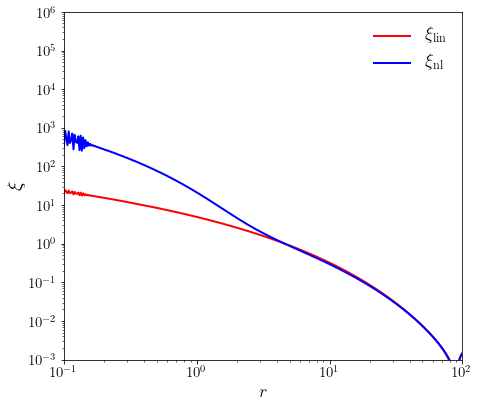

In [196]:
fig, ax = pl.subplots(1,1, figsize = (7,6))
indz = np.where(PS.z_array > 0.1)[0][0]
ax.plot(r,(xitot_lin_mat)[indz,:], color='r',lw=2,ls='-',label=r'$\xi_{\rm lin}$')
ax.plot(r,(xitot_nl_mat)[indz,:], color='b',lw=2,ls='-',label=r'$\xi_{\rm nl}$')

ax.set_xscale('log')
ax.set_yscale('log')
ax.set_xlabel(r'$r$', size = 18)
ax.set_ylabel(r'$\xi$', size = 20)
ax.set_ylim(1e-3,1e6)
ax.set_xlim(0.1,100)
ax.tick_params(axis='both', which='major', labelsize=15)
ax.tick_params(axis='both', which='minor', labelsize=15)
ax.legend(fontsize = 18, frameon = False)
pl.tight_layout()




In [14]:
PS.bm_array.shape, PS.M_array.shape, PS.z_array.shape


((100, 500), (500,), (100,))

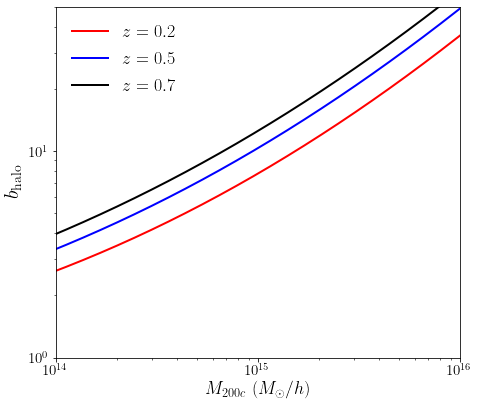

In [15]:
fig, ax = pl.subplots(1,1, figsize = (7,6))
indz = np.where(PS.z_array > 0.2)[0][0]
ax.plot(PS.M_array,(PS.bm_array)[indz,:], color='r',lw=2,ls='-',label=r'$z=0.2$')
indz = np.where(PS.z_array > 0.5)[0][0]
ax.plot(PS.M_array,(PS.bm_array)[indz,:], color='b',lw=2,ls='-',label=r'$z=0.5$')
indz = np.where(PS.z_array > 0.7)[0][0]
ax.plot(PS.M_array,(PS.bm_array)[indz,:], color='k',lw=2,ls='-',label=r'$z=0.7$')
ax.set_xscale('log')
ax.set_yscale('log')
ax.set_xlabel(r'$M_{200c}$ ($M_{\odot}/h$)', size = 18)
ax.set_ylabel(r'$b_{\rm halo}$', size = 20)
ax.set_ylim(1,50)
ax.set_xlim(1e14,1e16)
ax.tick_params(axis='both', which='major', labelsize=15)
ax.tick_params(axis='both', which='minor', labelsize=15)
ax.legend(fontsize = 18, frameon = False)
pl.tight_layout()




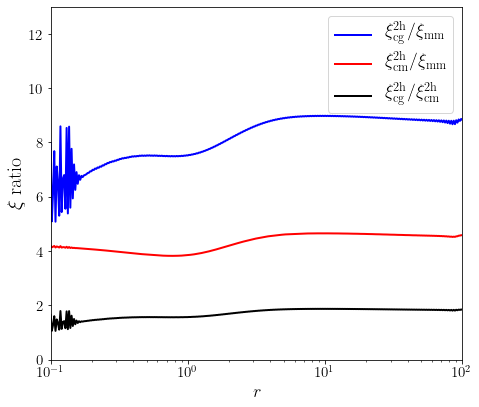

In [16]:
fig, ax = pl.subplots(1,1, figsize = (7,6))
indz = np.where(PS.z_array > 0.5)[0][0]

ax.plot(r,(xicg_2h_nl_mat[jz,:])/(xitot_nl_mat)[indz,:], color='b',lw=2,ls='-',label=r'$\xi^{\rm 2h}_{\rm cg}/\xi_{\rm mm}$')
ax.plot(r,(xicm_2h_nl_mat[jz,:])/(xitot_nl_mat)[indz,:], color='r',lw=2,ls='-',label=r'$\xi^{\rm 2h}_{\rm cm}/\xi_{\rm mm}$')
ax.plot(r,(xicg_2h_nl_mat[jz,:])/(xicm_2h_nl_mat)[indz,:], color='k',lw=2,ls='-',label=r'$\xi^{\rm 2h}_{\rm cg}/\xi^{\rm 2h}_{\rm cm}$')  
ax.set_xscale('log')
# ax.set_yscale('log')
ax.set_xlabel(r'$r$', size = 18)
ax.set_ylabel(r'$\xi$ ratio', size = 20)
ax.set_ylim(0,13)
ax.set_xlim(0.1,100)
ax.tick_params(axis='both', which='major', labelsize=15)
ax.tick_params(axis='both', which='minor', labelsize=15)
ax.legend(fontsize = 18)
pl.tight_layout()




In [197]:
from mcfit import P2xi
from mcfit import xi2P
import scipy.interpolate as interpolate
from mcfit import Hankel
k_array_hres = np.logspace(-4.8,np.log10(1000),100000)

wprp_mm_lin_mat = np.zeros((Plin_kz.shape[0], len(k_array) - 1))
Deltawprp_mm_lin_mat = np.zeros((Plin_kz.shape[0], len(k_array) - 1))
units = PS.rho_m_bar

for jz in range(len(PS.z_array)):
    rp_out, wprp_out = Hankel(k_array, nu=0, q=1.0)(Plin_kz[jz,:], extrap=True)
    wprp_out *= (1 / (2 * np.pi))
    drp_out = rp_out[1:] - rp_out[:-1]
    rp_cen = 0.5*(rp_out[1:] + rp_out[:-1])
    
    wprp_cen = 0.5*(wprp_out[1:] + wprp_out[:-1])
    wprp_mm_lin_mat[jz,:] = wprp_cen
    
    wprp_ltr = (2./(rp_cen**2))*np.cumsum(drp_out * rp_cen * wprp_cen)
    Deltawprp_mm_lin_mat[jz,:] = wprp_ltr - wprp_cen

wprp_mm_nl_mat = np.zeros((Plin_kz.shape[0], len(k_array) - 1))
Deltawprp_mm_nl_mat = np.zeros((Plin_kz.shape[0], len(k_array) - 1))
units = PS.rho_m_bar

for jz in range(len(PS.z_array)):
    rp_out, wprp_out = Hankel(k_array, nu=0, q=1.0)(Pnl_kz[jz,:], extrap=True)
    wprp_out *= (1 / (2 * np.pi))
    drp_out = rp_out[1:] - rp_out[:-1]
    rp_cen = 0.5*(rp_out[1:] + rp_out[:-1])
    
    wprp_cen = 0.5*(wprp_out[1:] + wprp_out[:-1])
    wprp_mm_nl_mat[jz,:] = wprp_cen
    
    wprp_ltr = (2./(rp_cen**2))*np.cumsum(drp_out * rp_cen * wprp_cen)
    Deltawprp_mm_nl_mat[jz,:] = wprp_ltr - wprp_cen
wprp_interp = interpolate.RectBivariateSpline(PS.z_array, np.log(rp_cen), rp_cen*(wprp_mm_nl_mat))


  

In [19]:
# wprp_cm_2hnl_mat = np.zeros((Plin_kz.shape[0], len(k_array) - 1))
# Deltawprp_cm_2hnl_mat = np.zeros((Plin_kz.shape[0], len(k_array) - 1))
# units = PS.rho_m_bar

# for jz in range(len(PS.z_array)):
#     rp_out, wprp_out = Hankel(k_array, nu=0, q=1.0)(Pk2h_nl[jz,:], extrap=True)
#     wprp_out *= (1 / (2 * np.pi))
#     drp_out = rp_out[1:] - rp_out[:-1]
#     rp_cen = 0.5*(rp_out[1:] + rp_out[:-1])
    
#     wprp_cen = 0.5*(wprp_out[1:] + wprp_out[:-1])
#     wprp_cm_2hnl_mat[jz,:] = wprp_cen
    
#     wprp_ltr = (2./(rp_cen**2))*np.cumsum(drp_out * rp_cen * wprp_cen)
#     Deltawprp_cm_2hnl_mat[jz,:] = wprp_ltr - wprp_cen



In [45]:
# wprp_cg_2hnl_mat = np.zeros((Plin_kz.shape[0], len(k_array) - 1))
# Deltawprp_cg_2hnl_mat = np.zeros((Plin_kz.shape[0], len(k_array) - 1))
# units = PS.rho_m_bar

# for jz in range(len(PS.z_array)):
#     rp_out, wprp_out = Hankel(k_array, nu=0, q=1.0)(Pk2h_cg_nl[jz,:], extrap=True)
#     wprp_out *= (1 / (2 * np.pi))
#     drp_out = rp_out[1:] - rp_out[:-1]
#     rp_cen = 0.5*(rp_out[1:] + rp_out[:-1])
    
#     wprp_cen = 0.5*(wprp_out[1:] + wprp_out[:-1])
#     wprp_cg_2hnl_mat[jz,:] = wprp_cen
    
#     wprp_ltr = (2./(rp_cen**2))*np.cumsum(drp_out * rp_cen * wprp_cen)
#     Deltawprp_cg_2hnl_mat[jz,:] = wprp_ltr - wprp_cen



In [198]:
dfc = np.load('advact_SNRgt4_z0.15-0.7_redshifts.npz')
# list(dfc.keys())
bin_min = 0.0
bin_max = 4.0
nbins_hist = 401
delta_bin = (bin_max - bin_min) / nbins_hist
bin_centers_all = np.linspace(bin_min, bin_max, nbins_hist)
bin_edges = (bin_centers_all[1:] + bin_centers_all[:-1])/2.
bin_centers = bin_centers_all[1:-1]

nz_hist, z_edges = np.histogram(dfc['z'], bins=bin_edges)
nc_norm = nz_hist/sp.integrate.simps(nz_hist,bin_centers)





(22, 400) (401,) (22,)


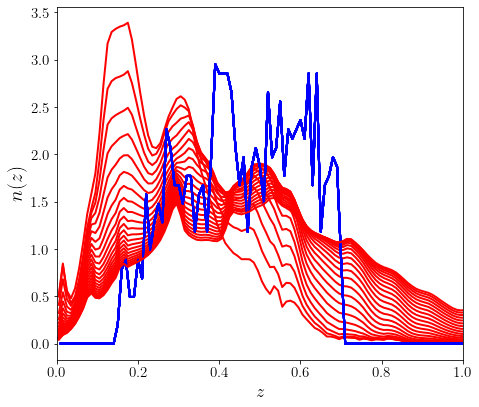

In [199]:
dfg = np.load('nofz_z0.15-0.7_bpz_y3gold_m22.5_M-19.87_new.npz')
list(dfg.keys())
print(dfg['count'].shape, dfg['zbins_nz'].shape, dfg['zbins'].shape)
zarr_cen = 0.5*(dfg['zbins_nz'][1:] + dfg['zbins_nz'][:-1])
fig, ax = pl.subplots(1,1, figsize = (7,6))
for jz in range(len(dfg['zbins'])):
    ng_unnorm = dfg['count'][jz,:]
    Ng_tot = np.sum(ng_unnorm)
    ng_norm = ng_unnorm/sp.integrate.simps(ng_unnorm,zarr_cen)
    
    ax.plot(bin_centers,nc_norm, color='b',lw=2,ls='-',label='Clusters')
    ax.plot(zarr_cen,ng_norm, color='r',lw=2,ls='-',label='Galaxies')
    ax.set_xlabel(r'$z$', size = 18)
    ax.set_ylabel(r'$n(z)$', size = 20)
    ax.tick_params(axis='both', which='major', labelsize=15)
    ax.tick_params(axis='both', which='minor', labelsize=15)
    ax.set_xlim(0.0,1.0)
#     ax.legend(fontsize = 18, frameon = False)
pl.tight_layout()


['hist', 'zbin']
(22, 400) (401,)


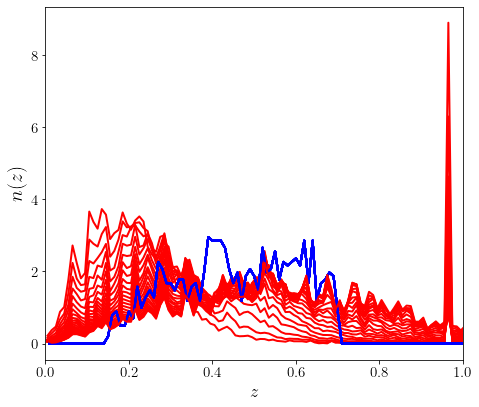

In [200]:
dfg2 = np.load('nofz_Nz22_0.15-0.7.npz')
print(list(dfg2.keys()))
print(dfg2['hist'].shape, dfg2['zbin'].shape)
# zarr_cen = 0.5*(dfg['zbins_nz'][1:] + dfg['zbins_nz'][:-1])
fig, ax = pl.subplots(1,1, figsize = (7,6))
for jz in range(len(dfg['zbins'])):
    ng_unnorm = dfg2['hist'][jz,:]
    Ng_tot = np.sum(ng_unnorm)
    ng_norm = ng_unnorm/sp.integrate.simps(ng_unnorm,zarr_cen)
    
    ax.plot(bin_centers,nc_norm, color='b',lw=2,ls='-',label='Clusters')
    ax.plot(zarr_cen,ng_norm, color='r',lw=2,ls='-',label='Galaxies')
    ax.set_xlabel(r'$z$', size = 18)
    ax.set_ylabel(r'$n(z)$', size = 20)
    ax.tick_params(axis='both', which='major', labelsize=15)
    ax.tick_params(axis='both', which='minor', labelsize=15)
    ax.set_xlim(0.0,1.0)
#     ax.legend(fontsize = 18, frameon = False)
pl.tight_layout()


In [201]:
# Sigma_g_meanv = 0
# for jc in range(len(zc_all)):
#     ng_unnorm = dfg['count'][jc,:]
#     Ng_tot = np.sum(ng_unnorm)
#     ng_norm = ng_unnorm/sp.integrate.simps(ng_unnorm,zarr_cen)
#     ng_intp = interpolate.interp1d(zarr_cen,ng_norm)
#     ng_norm = ng_intp(PS.z_array)
#     rhog_z = ng_norm * Ng_tot/((4*np.pi*0.108)*(PS.chi_array**2)*(PS.dchi_dz_array))
#     nc_intp = interpolate.interp1d(bin_centers,nc_norm)
#     nc_val = nc_intp(zc_all[jc])
#     Sigma_g_meanv += nc_val * sp.integrate.simps(rhog_z,PS.chi_array)
# print(Sigma_g_meanv)



In [202]:
# zc_all



In [203]:
zg_all = zarr_cen
zc_all = dfg['zbins']
chi_interp = interpolate.interp1d(PS.z_array,np.log(PS.chi_array))
Sigma_g_meanv2 = 0
nc_total = 0
Sigma_g_bar_zarr = np.zeros(len(zc_all))
Sigma_g_mean_weighted = 0
for jc in range(len(zc_all)):
    ng_unnorm = dfg['count'][jc,:]
    Ng_tot = np.sum(ng_unnorm)
    print(Ng_tot)
    chiv = np.exp(chi_interp(zc_all[jc]))
    area = (4*np.pi*0.108)*(chiv**2)
    nc_intp = interpolate.interp1d(bin_centers,nc_norm)
    nc_val = nc_intp(zc_all[jc])
    Sigma_g_meanv2 += nc_val * Ng_tot/area
    nc_total += nc_val
    Sigma_g_bar_zarr[jc] = Ng_tot/area
    
Sigma_g_meanv2 = Sigma_g_meanv2/nc_total
print(Sigma_g_meanv2)

Sigma_g_interp = interpolate.interp1d(np.log(zc_all),Sigma_g_bar_zarr,fill_value='extrapolate')



2894206.0
4211789.0
5822694.0
7734239.0
9954683.0
12486341.0
15327069.0
18479812.0
21936234.0
25688123.0
29724672.0
34045248.0
38633070.0
43476790.0
48565366.0
53882482.0
59404179.0
65095047.0
70916430.0
76803373.0
82704789.0
88530297.0
18.005188181966062


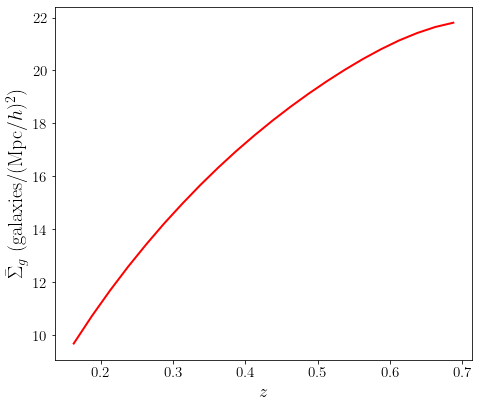

In [204]:
fig, ax = pl.subplots(1,1, figsize = (7,6))

ax.plot(zc_all,Sigma_g_bar_zarr, color='r',lw=2,ls='-')

# ax.set_xscale('log')
# ax.set_yscale('log')
ax.set_xlabel(r'$z$', size = 18)
ax.set_ylabel(r'$\bar{\Sigma}_g$ (galaxies/$({\rm Mpc}/h)^2$)', size = 20)
# ax.set_ylim(1e-1,1e3)
# ax.set_xlim(0.1,80)
ax.tick_params(axis='both', which='major', labelsize=15)
ax.tick_params(axis='both', which='minor', labelsize=15)
# ax.legend(fontsize = 15)
pl.tight_layout()




In [205]:
dfgold = fits.open('/global/cfs/cdirs/des/data_actxdes/y3gold2.2_select_clr-magerr0.1_m22.5.fits')
# dfgold[1].header
zc_all


array([0.1625, 0.1875, 0.2125, 0.2375, 0.2625, 0.2875, 0.3125, 0.3375,
       0.3625, 0.3875, 0.4125, 0.4375, 0.4625, 0.4875, 0.5125, 0.5375,
       0.5625, 0.5875, 0.6125, 0.6375, 0.6625, 0.6875])

In [28]:
zg_all = zarr_cen
zg_all = zarr_cen
zc_all = dfg['zbins']
dzc = zc_all[1] - zc_all[0]
zc_all_ext = np.hstack(([zc_all[0] - dzc], zc_all, [zc_all[-1] + dzc]))
zc_edges_all = 0.5*(zc_all_ext[1:] + zc_all_ext[:-1])
zc_edges_min = zc_edges_all[:-1]
zc_edges_max = zc_edges_all[1:]
chi_interp = interpolate.interp1d(PS.z_array,np.log(PS.chi_array))
Sigma_g_meanv2 = 0
nc_total = 0
Sigma_g_bar_zarr = np.zeros(len(zc_all))
Sigma_g_mean_weighted = 0
for jc in range(len(zc_all)):
#     ng_unnorm = dfg['count'][jc,:]
    ng_unnorm = dfg2['hist'][jc,:]
    Ng_tot = np.sum(ng_unnorm)
#     print(Ng_tot)
    chiv = np.exp(chi_interp(zc_all[jc]))
    area = (4*np.pi*0.108)*(chiv**2)
    ind_sel = np.where((dfc['z'] >= zc_edges_min[jc])  & (dfc['z'] < zc_edges_max[jc]))[0]
    nc_val = len(ind_sel)
    Sigma_g_meanv2 += nc_val * Ng_tot/area
    nc_total += nc_val
    Sigma_g_bar_zarr[jc] = Ng_tot/area
    
Sigma_g_meanv2 = Sigma_g_meanv2/nc_total
# print(Sigma_g_meanv2)


chi_interp = interpolate.interp1d(PS.z_array, np.log(PS.chi_array),fill_value='extrapolate')
chi_cen = np.exp(chi_interp(zarr_cen))

dchi_dz_interp = interpolate.interp1d(PS.z_array, np.log(PS.dchi_dz_array),fill_value='extrapolate')
dchi_dz_cen = np.exp(dchi_dz_interp(zarr_cen))

pkznl_interp = interpolate.RectBivariateSpline(PS.z_array, np.log(k_array), np.log(Pnl_kz))
pkzlin_interp = interpolate.RectBivariateSpline(PS.z_array, np.log(k_array), np.log(Plin_kz))



zg_all = zarr_cen
zc_all = dfg['zbins']
dzc = zc_all[1] - zc_all[0]
zc_all_ext = np.hstack(([zc_all[0] - dzc], zc_all, [zc_all[-1] + dzc]))
zc_edges_all = 0.5*(zc_all_ext[1:] + zc_all_ext[:-1])
zc_edges_min = zc_edges_all[:-1]
zc_edges_max = zc_edges_all[1:]

zcen_hres = np.linspace(0.05,1.0,500)
dzc = zcen_hres[1] - zcen_hres[0]
zcen_hres_all_ext = np.hstack(([zcen_hres[0] - dzc], zcen_hres, [zcen_hres[-1] + dzc]))
zcen_hres_edges = 0.5*(zcen_hres_all_ext[1:] + zcen_hres_all_ext[:-1])
dfg = np.load('nofz_z0.15-0.7_bpz_y3gold_m22.5_M-19.87.npz')
zarr_cen = 0.5*(dfg['zbins_nz'][1:] + dfg['zbins_nz'][:-1])
ng_norm_hres = np.zeros((len(dfg['zbins']),len(zcen_hres)))
for jz in range(len(dfg['zbins'])):
#     ng_unnorm = dfg['count'][jz,:]
    ng_unnorm = dfg2['hist'][jz,:]
    ng_norm = ng_unnorm/sp.integrate.simps(ng_unnorm,zarr_cen)
    ng_interp = interpolate.interp1d(zarr_cen,ng_norm)
    ng_norm_hres[jz,:] = ng_interp(zcen_hres)
    
chi_cen_hres = np.exp(chi_interp(zcen_hres))
dchi_dz_cen_hres = np.exp(dchi_dz_interp(zcen_hres))

    
nc_intp = interpolate.interp1d(bin_centers,nc_norm)
ell_array = np.logspace(-1,5,100)
rp_array = np.logspace(-2,2,100)
wt_all = np.zeros((len(rp_array),len(zc_all)))
theta_all = np.zeros((len(rp_array),len(zc_all)))
nc_mat_all = np.zeros((len(rp_array),len(zc_all)))

for jc in range(len(zc_all)):
# for jc in range(1):
    ng_unnorm = ng_norm_hres[jc,:]
    ng_norm_jc = ng_unnorm/sp.integrate.simps(ng_unnorm,zcen_hres)
    
    ind_sel = np.where((dfc['z'] >= zc_edges_min[jc])  & (dfc['z'] < zc_edges_max[jc]))[0]
    nz_hist, z_edges = np.histogram(dfc['z'][ind_sel], bins=zcen_hres_edges)
    nc_norm_jc = nz_hist/sp.integrate.simps(nz_hist,zcen_hres)  
    
#     print(nc_norm_jc)
    
    Cell_array_jc = np.zeros_like(ell_array)
    for jl in range(len(Cell_array_jc)):
        karray_jl = ell_array[jl]/chi_cen_hres
        Pkmm_jl = np.exp(pkznl_interp((zcen_hres), np.log(karray_jl),grid=False))
        integrand_jl = Pkmm_jl * nc_norm_jc*ng_norm_jc/((chi_cen_hres**2) * dchi_dz_cen_hres)
        Cell_array_jc[jl] = sp.integrate.simps(integrand_jl,zcen_hres)
    
#     print(Cell_array_jc)
    
    l_array_full = np.logspace(-1,5, 100000)
    Cell_interp = interpolate.interp1d(np.log(ell_array), np.log(Cell_array_jc), fill_value='extrapolate',
                                       bounds_error=False)
    Cell_full = np.exp(Cell_interp(np.log(l_array_full)))
#     print(Cell_full)
    theta_out, wtheta_jc = Hankel(l_array_full, nu=0, q=1.0)(Cell_full, extrap=False)
#     print(wtheta_jc)
    wtheta_jc *= (1 / (2 * np.pi))
    
    chi_zc = np.exp(chi_interp(zc_all[jc]))
    theta_arr_jc = rp_array/chi_zc
#     print(theta_arr_jc)
    
    wt_interp = interpolate.interp1d(np.log(theta_out),theta_out*(wtheta_jc), fill_value='extrapolate')
    wt_all[:,jc] = (wt_interp(np.log(theta_arr_jc)))/theta_arr_jc
    theta_all[:,jc] = theta_arr_jc
#     print(wt_all[:,jc])
    
    nc_val = nc_intp(zc_all[jc])
    nc_mat_all[:,jc] = nc_val * np.ones(len(rp_array))    
    
    

Sigmag_bar = Sigma_g_meanv2

Sigmag_mm_nl_val_dnf = Sigmag_bar * sp.integrate.simps((wt_all*nc_mat_all),zc_all)/(sp.integrate.simps((nc_mat_all),zc_all))

    

/global/u1/s/spandey/self_module_ini/myenv3/lib/python3.7/site-packages/mcfit/mcfit.py:126: UserWarning: The default value of lowring has been changed to False, set it to True if you cannot reproduce previous results
  warnings.warn("The default value of lowring has been changed to False, "
/global/u1/s/spandey/self_module_ini/myenv3/lib/python3.7/site-packages/mcfit/mcfit.py:217: UserWarning: The default value of extrap has been changed to False, set it to True if you cannot reproduce previous results
  warnings.warn("The default value of extrap has been changed to False, "


In [210]:
dfg = np.load('nofz_z0.15-0.7_bpz_y3gold_m22.5_M-19.87_new.npz')
zg_all = zarr_cen
zg_all = zarr_cen
zc_all = dfg['zbins']
dzc = zc_all[1] - zc_all[0]
zc_all_ext = np.hstack(([zc_all[0] - dzc], zc_all, [zc_all[-1] + dzc]))
zc_edges_all = 0.5*(zc_all_ext[1:] + zc_all_ext[:-1])
zc_edges_min = zc_edges_all[:-1]
zc_edges_max = zc_edges_all[1:]
chi_interp = interpolate.interp1d(PS.z_array,np.log(PS.chi_array))
Sigma_g_meanv2 = 0
nc_total = 0
Sigma_g_bar_zarr = np.zeros(len(zc_all))
Sigma_g_mean_weighted = 0
for jc in range(len(zc_all)):
    ng_unnorm = dfg['count'][jc,:]
#     ng_unnorm = dfg2['hist'][jc,:]
    Ng_tot = np.sum(ng_unnorm)
#     print(Ng_tot)
    chiv = np.exp(chi_interp(zc_all[jc]))
    area = (4*np.pi*0.108)*(chiv**2)
    ind_sel = np.where((dfc['z'] >= zc_edges_min[jc])  & (dfc['z'] < zc_edges_max[jc]))[0]
    nc_val = len(ind_sel)
    Sigma_g_meanv2 += nc_val * Ng_tot/area
    nc_total += nc_val
    Sigma_g_bar_zarr[jc] = Ng_tot/area
    
Sigma_g_meanv2 = Sigma_g_meanv2/nc_total
# print(Sigma_g_meanv2)


chi_interp = interpolate.interp1d(PS.z_array, np.log(PS.chi_array),fill_value='extrapolate')
chi_cen = np.exp(chi_interp(zarr_cen))

dchi_dz_interp = interpolate.interp1d(PS.z_array, np.log(PS.dchi_dz_array),fill_value='extrapolate')
dchi_dz_cen = np.exp(dchi_dz_interp(zarr_cen))

pkznl_interp = interpolate.RectBivariateSpline(PS.z_array, np.log(k_array), np.log(Pnl_kz))
pkzlin_interp = interpolate.RectBivariateSpline(PS.z_array, np.log(k_array), np.log(Plin_kz))



zg_all = zarr_cen
zc_all = dfg['zbins']
dzc = zc_all[1] - zc_all[0]
zc_all_ext = np.hstack(([zc_all[0] - dzc], zc_all, [zc_all[-1] + dzc]))
zc_edges_all = 0.5*(zc_all_ext[1:] + zc_all_ext[:-1])
zc_edges_min = zc_edges_all[:-1]
zc_edges_max = zc_edges_all[1:]

zcen_hres = np.linspace(0.05,1.0,500)
dzc = zcen_hres[1] - zcen_hres[0]
zcen_hres_all_ext = np.hstack(([zcen_hres[0] - dzc], zcen_hres, [zcen_hres[-1] + dzc]))
zcen_hres_edges = 0.5*(zcen_hres_all_ext[1:] + zcen_hres_all_ext[:-1])

zarr_cen = 0.5*(dfg['zbins_nz'][1:] + dfg['zbins_nz'][:-1])
ng_norm_hres = np.zeros((len(dfg['zbins']),len(zcen_hres)))
for jz in range(len(dfg['zbins'])):
    ng_unnorm = dfg['count'][jz,:]
#     ng_unnorm = dfg2['hist'][jz,:]
    ng_norm = ng_unnorm/sp.integrate.simps(ng_unnorm,zarr_cen)
    ng_interp = interpolate.interp1d(zarr_cen,ng_norm)
    ng_norm_hres[jz,:] = ng_interp(zcen_hres)
    
chi_cen_hres = np.exp(chi_interp(zcen_hres))
dchi_dz_cen_hres = np.exp(dchi_dz_interp(zcen_hres))

    
nc_intp = interpolate.interp1d(bin_centers,nc_norm)
ell_array = np.logspace(-1,5,100)
rp_array = np.logspace(-2,2,100)
wt_all = np.zeros((len(rp_array),len(zc_all)))
theta_all = np.zeros((len(rp_array),len(zc_all)))
nc_mat_all = np.zeros((len(rp_array),len(zc_all)))

Cell_mat1 = np.zeros((len(ell_array),len(zc_all)))
Cell_mat2 = np.zeros((len(ell_array),len(zc_all)))
wt_all2 = np.zeros((len(rp_array),len(zc_all)))

for jc in range(len(zc_all)):
# for jc in range(1):
    ng_unnorm = ng_norm_hres[jc,:]
    ng_norm_jc = ng_unnorm/sp.integrate.simps(ng_unnorm,zcen_hres)
    
    ind_sel = np.where((dfc['z'] >= zc_edges_min[jc])  & (dfc['z'] < zc_edges_max[jc]))[0]
    nz_hist, z_edges = np.histogram(dfc['z'][ind_sel], bins=zcen_hres_edges)
    nc_norm_jc = nz_hist/sp.integrate.simps(nz_hist,zcen_hres)  
    
#     print(nc_norm_jc)
    
    Cell_array_jc = np.zeros_like(ell_array)
    for jl in range(len(Cell_array_jc)):
        karray_jl = ell_array[jl]/chi_cen_hres
        Pkmm_jl = np.exp(pkznl_interp((zcen_hres), np.log(karray_jl),grid=False))
        integrand_jl = Pkmm_jl * nc_norm_jc*ng_norm_jc/((chi_cen_hres**2) * dchi_dz_cen_hres)
        Cell_array_jc[jl] = sp.integrate.simps(integrand_jl,zcen_hres)
    Cell_mat1[:,jc] = Cell_array_jc
    
    ng_norm_interp_jc = interpolate.interp1d(zcen_hres, ng_norm_jc)
    ngv_jc = ng_norm_interp_jc(zc_all[jc])
    chiv_jc = np.exp(chi_interp(zc_all[jc]))
    dchidzv_jc = np.exp(dchi_dz_interp(zc_all[jc]))
    kv_jc = ell_array/(chiv_jc)
    Pkmm_jc = np.exp(pkznl_interp((zc_all[jc])*np.ones_like(kv_jc), np.log(kv_jc),grid=False))
    Cell_array_jc2 = (ngv_jc/((chiv_jc**2) * dchidzv_jc))*Pkmm_jc
    Cell_mat2[:,jc] = Cell_array_jc2

    
    l_array_full = np.logspace(-1,5, 100000)
    Cell_interp = interpolate.interp1d(np.log(ell_array), np.log(Cell_array_jc), fill_value='extrapolate',
                                       bounds_error=False)
    Cell_full = np.exp(Cell_interp(np.log(l_array_full)))
#     print(Cell_full)
    theta_out, wtheta_jc = Hankel(l_array_full, nu=0, q=1.0)(Cell_full, extrap=False)
#     print(wtheta_jc)
    wtheta_jc *= (1 / (2 * np.pi))
    
    chi_zc = np.exp(chi_interp(zc_all[jc]))
    theta_arr_jc = rp_array/chi_zc
#     print(theta_arr_jc)
    
    wt_interp = interpolate.interp1d(np.log(theta_out),theta_out*(wtheta_jc), fill_value='extrapolate')
    wt_all[:,jc] = (wt_interp(np.log(theta_arr_jc)))/theta_arr_jc
    theta_all[:,jc] = theta_arr_jc
#     print(wt_all[:,jc])
    
    wprp_all2 = (wprp_interp((zc_all[jc])*np.ones_like(rp_array),np.log(rp_array),grid=False))/rp_array
    wt_all2[:,jc] = (ngv_jc/(dchidzv_jc))*wprp_all2
    
    nc_val = nc_intp(zc_all[jc])
    nc_mat_all[:,jc] = nc_val * np.ones(len(rp_array))    
    
    

Sigmag_bar = Sigma_g_meanv2

Sigmag_mm_nl_val_bpz = Sigmag_bar * sp.integrate.simps((wt_all*nc_mat_all),zc_all)/(sp.integrate.simps((nc_mat_all),zc_all))

    

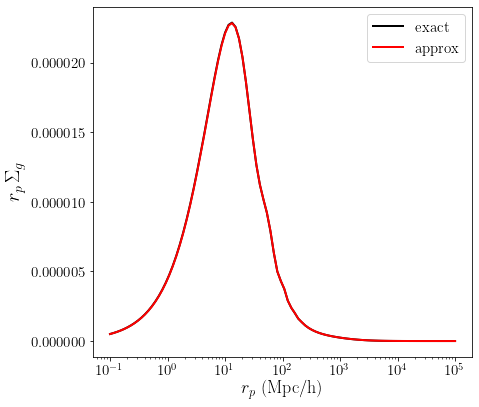

In [39]:
fig, ax = pl.subplots(1,1, figsize = (7,6))
ax.plot(ell_array,Cell_mat1[:,5], color='k',lw=2,ls='-',label=r'exact')
ax.plot(ell_array,Cell_mat2[:,5], color='r',lw=2,ls='-',label=r'approx')

ax.set_xscale('log')
# ax.set_yscale('log')
ax.set_xlabel(r'$r_p$ (Mpc/h)', size = 18)
ax.set_ylabel(r'$r_p \,\Sigma_g$', size = 20)
# ax.set_ylim(1e-2,2e2)
# ax.set_ylim(2e0,14)
# ax.set_xlim(0.1,80)
ax.tick_params(axis='both', which='major', labelsize=15)
ax.tick_params(axis='both', which='minor', labelsize=15)
ax.legend(fontsize = 15,loc='upper right')
pl.tight_layout()





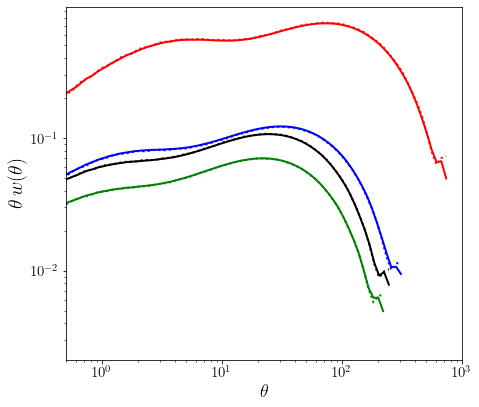

In [53]:
fig, ax = pl.subplots(1,1, figsize = (7,6))
jarr = np.array([0,10,15,18])
colors = ['r','b','k','g']
k=0
for jc in jarr:      
    chi_zc = np.exp(chi_interp(zc_all[jc]))
    theta_arr_jc = rp_data2/chi_zc
    theta_arr_jc *= 180.*60./np.pi
    
    wt_theory_jc = wt_all[:,jc]
    theta_theory_jc = np.copy(theta_all[:,jc])
    theta_theory_jc *= 180.*60./np.pi
           
    ax.plot(theta_theory_jc,theta_theory_jc*wt_all[:,jc], color=colors[k],lw=2,ls='-')
    ax.plot(theta_theory_jc,theta_theory_jc*wt_all2[:,jc], color=colors[k],lw=2,ls=':')
    k+=1
# ax.plot(rp_cen,rp_cen*Sigmag_cg_2hnl_val*12.56, color='r',lw=2,ls='-',label=r'Theory HOD')

# ax.errorbar(rp_data2,sig_cg_data, rp_data2*np.sqrt(np.diag(df1['cov'])),color='b',lw=2,ls='',marker='o',ms=3.0)

ax.set_xscale('log')
ax.set_yscale('log')
ax.set_xlabel(r'$\theta$', size = 18)
ax.set_ylabel(r'$\theta \, w(\theta)$', size = 20)
# ax.set_ylim(1e-2,2e2)
# ax.set_ylim(1e0,5e1)
ax.set_xlim(0.5,1e3)
ax.tick_params(axis='both', which='major', labelsize=15)
ax.tick_params(axis='both', which='minor', labelsize=15)
# ax.legend(fontsize = 15,loc='lower left')
pl.tight_layout()





In [206]:
df1 = np.load('Sig_advact_all_SNRgt4.0_nR25_0.14-85.71_z0.15-0.70_maglim22.5_final.npz')
rbin = np.logspace(np.log10(0.1),np.log10(60.),26)
rp_data2 = ((2./3.)*(rbin[1:]**3-rbin[:-1]**3)/(rbin[1:]**2-rbin[:-1]**2))
# # rp_data2 = np.logspace(np.log10(0.1),np.log10(60),25)

# sig_cg_data = df1['Sigma']
# xi_cg_data = df1['Xi']
list(df1.keys()), df1['Xiz'].shape


(['cov_Xi', 'Xiz', 'Xi', 'Sigma', 'cov'], (22, 25))

In [35]:
saved = {}
saved['rp'] = rp_array
saved['sig_cg_dnf'] = Sigmag_mm_nl_val_dnf*5.*1.5
saved['sig_cg_bpz'] = Sigmag_mm_nl_val_bpz*5.*1.5
pk.dump(saved,open('sig_cg_bpz_dnf.pk','wb'))



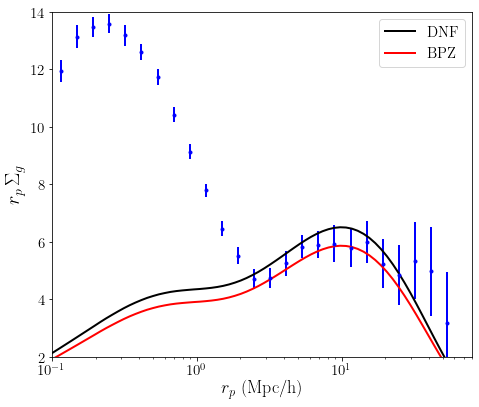

In [34]:
fig, ax = pl.subplots(1,1, figsize = (7,6))
# ax.plot(rp_cen,6*6*(Sigmag_mm_nl_norm*Sigma_g_mean2), color='r',lw=2,ls='-',label=r'Theory; PT w/$\langle b_c \rangle = 5.0, \langle b_g \rangle = 1.7$')
# ax.plot(rp_cen,4*(Sigmag_cg_nl_norm*Sigma_g_mean2), color='k',lw=2,ls='-',label=r'Theory; HOD w/$M_{\rm min} = 1.5\times 10^{14}M_{\odot}/h$'
       

ax.plot(rp_array,rp_array*Sigmag_mm_nl_val_dnf*5.*1.5, color='k',lw=2,ls='-',label=r'DNF')
ax.plot(rp_array,rp_array*Sigmag_mm_nl_val_bpz*5.*1.5, color='r',lw=2,ls='-',label=r'BPZ')
# ax.plot(rp_cen,rp_cen*Sigmag_cg_2hnl_val*12.56, color='r',lw=2,ls='-',label=r'Theory HOD')
ax.errorbar(rp_data2,rp_data2*sig_cg_data, rp_data2*np.sqrt(np.diag(df1['cov'])),color='b',lw=2,ls='',marker='o',ms=3.0)
# ax.errorbar(rp_data2,sig_cg_data, rp_data2*np.sqrt(np.diag(df1['cov'])),color='b',lw=2,ls='',marker='o',ms=3.0)

ax.set_xscale('log')
# ax.set_yscale('log')
ax.set_xlabel(r'$r_p$ (Mpc/h)', size = 18)
ax.set_ylabel(r'$r_p \,\Sigma_g$', size = 20)
# ax.set_ylim(1e-2,2e2)
ax.set_ylim(2e0,14)
ax.set_xlim(0.1,80)
ax.tick_params(axis='both', which='major', labelsize=15)
ax.tick_params(axis='both', which='minor', labelsize=15)
ax.legend(fontsize = 15,loc='upper right')
pl.tight_layout()





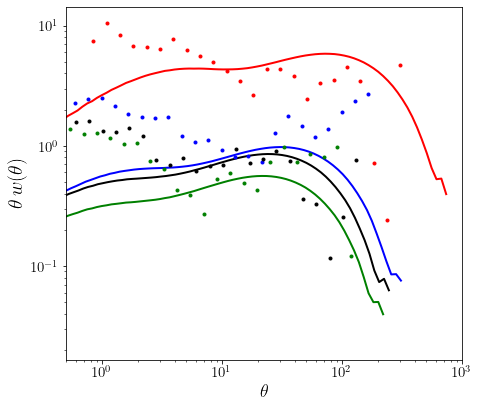

In [284]:
fig, ax = pl.subplots(1,1, figsize = (7,6))
jarr = np.array([0,10,15,18])
colors = ['r','b','k','g']
k=0
for jc in jarr:      
    chi_zc = np.exp(chi_interp(zc_all[jc]))
    theta_arr_jc = rp_data2/chi_zc
    theta_arr_jc *= 180.*60./np.pi
    
    wt_theory_jc = wt_all[:,jc]
    theta_theory_jc = np.copy(theta_all[:,jc])
    theta_theory_jc *= 180.*60./np.pi
    
    ax.errorbar(theta_arr_jc,theta_arr_jc*df1['Xiz'][jc,:],color=colors[k],lw=2,ls='',marker='o',ms=3.0)
       
    ax.plot(theta_theory_jc,theta_theory_jc*wt_theory_jc*5.*1.6, color=colors[k],lw=2,ls='-')
    k+=1
# ax.plot(rp_cen,rp_cen*Sigmag_cg_2hnl_val*12.56, color='r',lw=2,ls='-',label=r'Theory HOD')

# ax.errorbar(rp_data2,sig_cg_data, rp_data2*np.sqrt(np.diag(df1['cov'])),color='b',lw=2,ls='',marker='o',ms=3.0)

ax.set_xscale('log')
ax.set_yscale('log')
ax.set_xlabel(r'$\theta$', size = 18)
ax.set_ylabel(r'$\theta \, w(\theta)$', size = 20)
# ax.set_ylim(1e-2,2e2)
# ax.set_ylim(1e0,5e1)
ax.set_xlim(0.5,1e3)
ax.tick_params(axis='both', which='major', labelsize=15)
ax.tick_params(axis='both', which='minor', labelsize=15)
# ax.legend(fontsize = 15,loc='lower left')
pl.tight_layout()





array([1.10474888e+01, 1.07933170e+01, 1.05132777e+01, 1.02110772e+01,
       9.89347004e+00, 9.57089353e+00, 9.25778637e+00, 8.97217333e+00,
       8.73399628e+00, 8.56165403e+00, 8.46642573e+00, 8.44523648e+00,
       8.47379348e+00, 8.50429624e+00, 8.47369388e+00, 8.32717873e+00,
       8.05335048e+00, 7.71094029e+00, 7.41190736e+00, 7.23968580e+00,
       7.15123931e+00, 6.99486199e+00, 6.70718923e+00, 6.44502364e+00,
       6.31879758e+00, 6.13091010e+00, 5.83277314e+00, 5.66207112e+00,
       5.43208225e+00, 5.18971630e+00, 4.99317792e+00, 4.74580758e+00,
       4.52189799e+00, 4.31482739e+00, 4.06615071e+00, 3.83965027e+00,
       3.62569550e+00, 3.41030836e+00, 3.19289231e+00, 2.97706814e+00,
       2.77283065e+00, 2.58216795e+00, 2.37920278e+00, 2.20029058e+00,
       2.02437092e+00, 1.85561291e+00, 1.69585046e+00, 1.54298506e+00,
       1.40799390e+00, 1.28030315e+00, 1.16185551e+00, 1.05324300e+00,
       9.56204341e-01, 8.69461462e-01, 7.92714760e-01, 7.23394708e-01,
      

In [59]:
zg_all = zarr_cen
zc_all = dfg['zbins']
dzc = zc_all[1] - zc_all[0]
zc_all_ext = np.hstack(([zc_all[0] - dzc], zc_all, [zc_all[-1] + dzc]))
zc_edges_all = 0.5*(zc_all_ext[1:] + zc_all_ext[:-1])
zc_edges_min = zc_edges_all[:-1]
zc_edges_max = zc_edges_all[1:]


dchi_dz_intp = interpolate.interp1d(PS.z_array,PS.dchi_dz_array)
dchi_dz_zc = dchi_dz_intp(zc_all)
dchi_dz_zc_mat = np.tile(dchi_dz_zc.reshape(len(zc_all),1),(1,len(k_array) - 1))
wprp_mm_nl_interp = interpolate.RectBivariateSpline(PS.z_array, np.log(rp_cen), (wprp_mm_nl_mat)) 
wprp_mm_nl_zc_mat = (wprp_mm_nl_interp(zc_all, np.log(rp_cen))) 

wprp_cg_2hnl_interp = interpolate.RectBivariateSpline(PS.z_array, np.log(rp_cen), (wprp_cg_2hnl_mat)) 
wprp_cg_2hnl_zc_mat = (wprp_cg_2hnl_interp(zc_all, np.log(rp_cen))) 

ng_mat_zc = np.zeros((len(zc_all),len(k_array) - 1))
nc_mat_zc = np.zeros((len(zc_all),len(k_array) - 1))
for jc in range(len(zc_all)):
    ng_unnorm = dfg['count'][jc,:]
    ng_norm_jc = ng_unnorm/sp.integrate.simps(ng_unnorm,zarr_cen)
    
    ind_sel = np.where((dfc['z'] >= zc_edges_min[jc])  & (dfc['z'] < zc_edges_max[jc]))[0]
    nz_hist, z_edges = np.histogram(dfc['z'][ind_sel], bins=dfg['zbins_nz'])
    nc_norm_jc = nz_hist/sp.integrate.simps(nz_hist,zarr_cen)   
    
    
    
#     ng_intp = interpolate.interp1d(zarr_cen,ng_norm)
#     ng_val = ng_intp(zc_all[jc])
#     ng_mat_zc[jc,:] = ng_val * np.ones(len(k_array) - 1)
    
#     nc_intp = interpolate.interp1d(bin_centers,nc_norm)
#     nc_val = nc_intp(zc_all[jc])
#     nc_mat_zc[jc,:] = nc_val * np.ones(len(k_array) - 1)

# Sigmag_bar = 36.9
# Sigmag_bar = Sigma_g_meanv
Sigmag_bar = Sigma_g_meanv2
# Sigmag_mm_nl_val = Sigmag_bar* sp.integrate.simps((wprp_mm_nl_zc_mat*ng_mat_zc*nc_mat_zc/dchi_dz_zc_mat).T,zc_all)
# Sigmag_cg_2hnl_val = Sigmag_bar* sp.integrate.simps((wprp_cg_2hnl_zc_mat*ng_mat_zc*nc_mat_zc/dchi_dz_zc_mat).T,zc_all)

Sigmag_mm_nl_val = Sigmag_bar* sp.integrate.simps((wprp_mm_nl_zc_mat*ng_mat_zc*nc_mat_zc/dchi_dz_zc_mat).T,zc_all)/(sp.integrate.simps((nc_mat_zc).T,zc_all))
Sigmag_cg_2hnl_val = Sigmag_bar* sp.integrate.simps((wprp_cg_2hnl_zc_mat*ng_mat_zc*nc_mat_zc/dchi_dz_zc_mat).T,zc_all)/(sp.integrate.simps((nc_mat_zc).T,zc_all))

# print(Sigmag_val)

    

In [211]:
nz_interp = interpolate.interp1d(bin_centers,nz_hist)
nz_array = nz_interp(PS.z_array)
nz_array = nz_array/sp.integrate.simps(nz_array,PS.z_array)
nz_mat = np.tile(nz_array.reshape(len(PS.z_array),1),(1,len(k_array) - 1))

DeltaSigma_mm_nl_norm = sp.integrate.simps((nz_mat*Deltawprp_mm_nl_mat).T,PS.z_array )
DeltaSigma_cm_2hnl_norm = sp.integrate.simps((nz_mat*Deltawprp_cm_2hnl_mat).T,PS.z_array )




ValueError: x and y arrays must be equal in length along interpolation axis.

In [41]:
df_wtg = np.load('Sig_advact_all_SNRgt4.0_nR25_0.14-85.71_z0.45-0.70_maglim22.5.npz')
list(df_wtg.keys())


['cov_Xi', 'Xi', 'Sigma', 'cov']

In [42]:
df_wtg['Xi']


array([4.16028851e+00, 3.72209354e+00, 3.06340651e+00, 2.56495931e+00,
       2.00304828e+00, 1.44271347e+00, 1.01169343e+00, 6.98252388e-01,
       5.09486732e-01, 3.11150272e-01, 2.06776673e-01, 1.30406022e-01,
       9.01070284e-02, 7.02584622e-02, 6.68947091e-02, 6.05529427e-02,
       5.05785150e-02, 3.56718363e-02, 2.85557842e-02, 2.44177899e-02,
       1.29019449e-02, 9.08927820e-03, 7.25302899e-03, 4.72732746e-03,
       2.74229756e-03])

In [43]:
# ng_mat = np.zeros(((len(PS.z_array),len(k_array) - 1)))

# ng_interp = interpolate.interp1d(zarr_cen,ng_norm)
# ng_array = ng_interp(PS.z_array)
# ng_array = ng_array/sp.integrate.simps(ng_array,PS.z_array)

# dchi_dz_mat = np.tile(PS.dchi_dz_array.reshape(len(PS.z_array),1),(1,len(k_array) - 1))

# Sigmag_mm_nl_norm = sp.integrate.simps((nz_mat*ng_mat*wprp_mm_nl_mat/dchi_dz_mat).T,PS.z_array)
# Sigmag_cg_nl_norm = sp.integrate.simps((nz_mat*ng_mat*wprp_cg_2hnl_mat/dchi_dz_mat).T,PS.z_array )




In [44]:
# rhog_z = ng_array * Ng_tot/((PS.chi_array**2)*(PS.dchi_dz_array))
# Sigma_g_mean = sp.integrate.simps(rhog_z,PS.chi_array)
# Sigma_g_mean2 = sp.integrate.simps(rhog_z*nz_array,PS.chi_array)
# print(Sigma_g_mean,Sigma_g_mean2)



In [207]:
df1 = np.load('dsigma_advact_SNRgt4_z0.15-0.70_NR18_0.2-60.0_bpz.npz')  
df2 = np.load('boost_advact_SNRgt4_z0.15-0.70_NR18_0.2-60.0_bpz.npz')


dsig_data = df1['dsigma']*df2['boost']
rp_data = np.logspace(np.log10(0.2),np.log10(60),18)
sig_data = np.sqrt(np.diag(df1['cov'] + df2['cov']))





NameError: name 'DeltaSigma_mm_nl_norm' is not defined

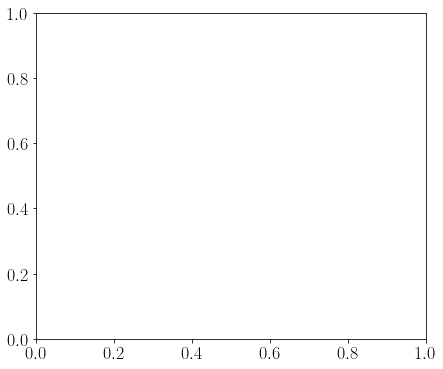

In [208]:
fig, ax = pl.subplots(1,1, figsize = (7,6))

ax.plot(rp_cen,5.*(DeltaSigma_mm_nl_norm), color='r',lw=2,ls='-',label=r'Theory; PT w/$\langle b_c \rangle = 5.0$')
ax.plot(rp_cen,(DeltaSigma_cm_2hnl_norm), color='k',lw=2,ls='-',label=r'Theory; HOD w/$M_{\rm min} = 1.5\times 10^{14}M_{\odot}/h$')
ax.errorbar(rp_data,dsig_data, sig_data,color='b',lw=2,ls='',marker='o',ms=3.0,label='Data')
ax.set_xscale('log')
ax.set_yscale('log')
ax.set_xlabel(r'$r_p$ (Mpc/h)', size = 18)
ax.set_ylabel(r'$\Delta \Sigma$', size = 20)
ax.set_ylim(1e-1,1e3)
ax.set_xlim(0.1,80)
ax.tick_params(axis='both', which='major', labelsize=15)
ax.tick_params(axis='both', which='minor', labelsize=15)
ax.legend(fontsize = 15)
pl.tight_layout()





In [54]:
# df1 = np.load('Sig_advact_all_SNRgt4.0_nR25_0.14-85.71_z0.15-0.70_maglim22.5.npz')
df1 = np.load('Sig_advact_all_SNRgt4.0_nR25_0.14-85.71_z0.15-0.70_maglim22.5_final.npz')
rbin = np.logspace(np.log10(0.1),np.log10(60.),26)
rp_data2 = ((2./3.)*(rbin[1:]**3-rbin[:-1]**3)/(rbin[1:]**2-rbin[:-1]**2))
# rp_data2 = np.logspace(np.log10(0.1),np.log10(60),25)

sig_cg_data = df1['Sigma']
xi_cg_data = df1['Xi']


In [55]:
# list(df1.keys())
df1['Xiz'].shape, len(zc_all)


((22, 25), 22)

NameError: name 'Sigmag_mm_nl_val' is not defined

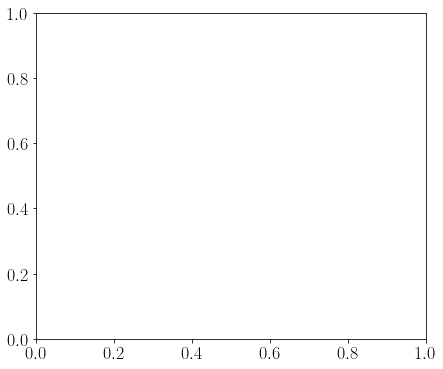

In [56]:
fig, ax = pl.subplots(1,1, figsize = (7,6))
# ax.plot(rp_cen,6*6*(Sigmag_mm_nl_norm*Sigma_g_mean2), color='r',lw=2,ls='-',label=r'Theory; PT w/$\langle b_c \rangle = 5.0, \langle b_g \rangle = 1.7$')
# ax.plot(rp_cen,4*(Sigmag_cg_nl_norm*Sigma_g_mean2), color='k',lw=2,ls='-',label=r'Theory; HOD w/$M_{\rm min} = 1.5\times 10^{14}M_{\odot}/h$'
       
       
ax.plot(rp_cen,rp_cen*Sigmag_mm_nl_val*5.*1.6*12.56, color='k',lw=2,ls='-',label=r'Theory PT')
ax.plot(rp_cen,rp_cen*Sigmag_cg_2hnl_val*12.56, color='r',lw=2,ls='-',label=r'Theory HOD')
ax.errorbar(rp_data2,rp_data2*sig_cg_data, rp_data2*np.sqrt(np.diag(df1['cov'])),color='b',lw=2,ls='',marker='o',ms=3.0)
# ax.errorbar(rp_data2,sig_cg_data, rp_data2*np.sqrt(np.diag(df1['cov'])),color='b',lw=2,ls='',marker='o',ms=3.0)

ax.set_xscale('log')
ax.set_yscale('log')
ax.set_xlabel(r'$r_p$ (Mpc/h)', size = 18)
ax.set_ylabel(r'$\Sigma_g$', size = 20)
# ax.set_ylim(1e-2,2e2)
ax.set_ylim(1e0,5e1)
ax.set_xlim(0.1,80)
ax.tick_params(axis='both', which='major', labelsize=15)
ax.tick_params(axis='both', which='minor', labelsize=15)
ax.legend(fontsize = 15,loc='lower left')
pl.tight_layout()





In [57]:
# logbase = 10.
# alphag = logbase**(-0.53)
# rsg = logbase**(-0.52)
# rtg = logbase**(0.34)
# betag = logbase**(0.82)
# gammag = logbase**(0.65)
# seg = 1.62
# rhosg = logbase**(1.7)
# rho0g = logbase**(-0.36)
# rhomaxg = 20.
# r0g = 1.5
# cmisg = np.exp(-1.08)
# fmisg = 0.11



In [69]:
(10**(-0.366627818816))


0.42990468816986377

In [59]:
# logbase = np.e
logbase = 10.
alphag = logbase**(-0.528117706205)
rsg = logbase**(-0.517543590629)
rtg = logbase**(0.342655276832)
betag = logbase**(0.822239352246)
gammag = logbase**(0.653421306975)
seg = 1.62067905305
rhosg = logbase**(1.70842945422)
rho0g = logbase**(-0.366627818816)
rhomaxg = 20.
r0g = 1.5
cmisg = np.exp(-1.07524021991)
fmisg = 0.107519826205
def get_DK_prof(r_array):
    rho_inner = rhosg*np.exp((-2./alphag)*((r_array/rsg)**(alphag) - 1))
    ftransr = (1. + (r_array/rtg)**(betag))**(-1.*gammag/betag)
    rho_outer = rho0g*1./(1./rhomaxg + (r_array/r0g)**(seg))
    rho_final = rho_inner * ftransr + rho_outer
    return rho_final, rho_inner, ftransr, rho_outer

rDK = np.logspace(-3,np.log10(20),100)
rho_DK, rho_inner, ftransr, rho_outer = get_DK_prof(rDK)
ind_sel = np.where(rDK < 0.05)[0]
rho_fix, _, _, _ = get_DK_prof(0.05)
rho_DK[ind_sel] = (np.ones(len(ind_sel)))*(rho_fix)



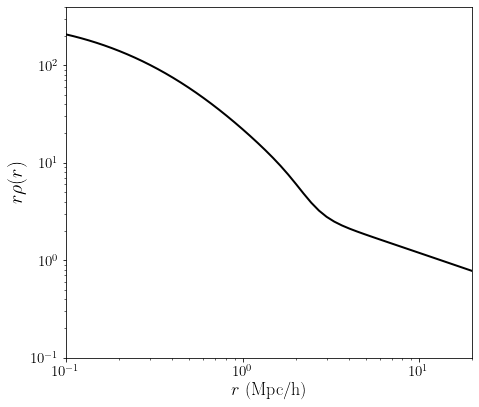

In [60]:
fig, ax = pl.subplots(1,1, figsize = (7,6))
       
ax.plot(rDK,6*rDK*rho_DK, color='k',lw=2,ls='-',label=r'Theory PT')

ax.set_xscale('log')
ax.set_yscale('log')
ax.set_xlabel(r'$r$ (Mpc/h)', size = 18)
ax.set_ylabel(r'$r \rho(r)$', size = 20)
# ax.set_ylim(1e-2,2e2)
ax.set_ylim(1e-1,4e2)
ax.set_xlim(0.1,20)
ax.tick_params(axis='both', which='major', labelsize=15)
ax.tick_params(axis='both', which='minor', labelsize=15)
# ax.legend(fontsize = 15,loc='lower left')
pl.tight_layout()


In [61]:
rp_min = 0.001
rp_max = 60
nrp = 300
lmax = 40
rp_arr = np.logspace(np.log10(rp_min), np.log10(rp_max),nrp)
Sigma_g_arr_DK = np.zeros(nrp)
for jrp in range(nrp):
    rpv = rp_arr[jrp]
    yarr = np.logspace(np.log10(1.0001*rpv),np.log10(np.sqrt(rpv**2 +lmax**2)),30000)
    rho_yarr, _, _, _ = get_DK_prof(yarr)
    int_yarr = 2.*rho_yarr * yarr/np.sqrt(yarr**2 - rpv**2)
    Sigma_g_arr_DK[jrp] = sp.integrate.simps(int_yarr, yarr)
    


In [62]:
rp_min = 0.001
rp_max = 30
nrpn = 400
rPi_min = 0.001
rPi_max = 40
nrPi = 400
rp_array = np.logspace(np.log10(rp_min), np.log10(rp_max),nrpn)
rPi_array = np.logspace(np.log10(rPi_min), np.log10(rPi_max),nrPi)
rp_mat = (np.tile(rp_array.reshape(nrpn, 1), (1, nrPi)))
rPi_mat = (np.tile(rPi_array.reshape(1,nrPi), (nrpn,1)))
rt_mat = np.sqrt(rp_mat**2 + rPi_mat**2)
rho_t_mat, _, _, _ = get_DK_prof(rt_mat)
Sigma_g_arr_DK2 = sp.integrate.simps(rho_t_mat, rPi_array)



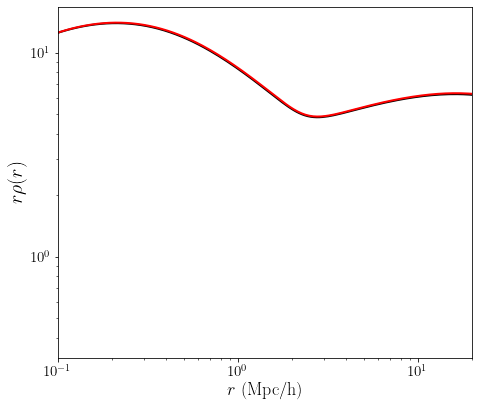

In [77]:
fig, ax = pl.subplots(1,1, figsize = (7,6))
       
ax.plot(rp_arr,rp_arr*Sigma_g_arr_DK, color='k',lw=2,ls='-',label=r'Theory PT')
ax.plot(rp_array,2.*rp_array*Sigma_g_arr_DK2, color='r',lw=2,ls='-',label=r'Theory PT')

ax.set_xscale('log')
ax.set_yscale('log')
ax.set_xlabel(r'$r$ (Mpc/h)', size = 18)
ax.set_ylabel(r'$r \rho(r)$', size = 20)
# ax.set_ylim(1e-2,2e2)
# ax.set_ylim(1e-1,4e2)
ax.set_xlim(0.1,20)
ax.tick_params(axis='both', which='major', labelsize=15)
ax.tick_params(axis='both', which='minor', labelsize=15)
# ax.legend(fontsize = 15,loc='lower left')
pl.tight_layout()


In [63]:
# Rmis_array = np.logspace(-3, np.log10(1.569), 200)
Rmis_array = np.linspace(0, (1.569), 200)
psi_array = np.linspace(0, 2 * np.pi, 50)
cospsi_array = np.cos(psi_array)
nRmis = len(Rmis_array)
npsi = len(psi_array)
Rmis_nRmis_npsi = (np.tile(Rmis_array.reshape(1, nRmis, 1), (nrp, 1, npsi)))
cospsi_nRmis_npsi = (np.tile(cospsi_array.reshape(1, 1, npsi), (nrp, nRmis, 1)))
Rmat_nRmis_npsi = (np.tile(rp_arr.reshape(nrp, 1, 1), (1, nRmis, npsi)))
R_arg_new = np.sqrt(
    Rmat_nRmis_npsi ** 2 + Rmis_nRmis_npsi ** 2 + 2 * Rmat_nRmis_npsi * Rmis_nRmis_npsi * cospsi_nRmis_npsi)



# Sigmag_interp = interpolate.interp1d(rp_arr, Sigma_g_arr_DK, fill_value=0.0, bounds_error=False)
# Sigmag_interp = interpolate.interp1d(rp_arr, Sigma_g_arr_DK, fill_value='extrapolate')
Sigmag_interp = interpolate.interp1d(np.hstack((0.0001,rp_arr)),np.hstack((Sigma_g_arr_DK[0],Sigma_g_arr_DK)),fill_value = "extrapolate")
Sigmag_argnew = Sigmag_interp(R_arg_new)

# Sigmag_intpsi = (1. / (2 * np.pi)) * sp.integrate.simps(Sigmag_argnew, psi_array)
Sigmag_intpsi = np.mean(Sigmag_argnew,axis=2)
# Sigmag_intpsi =  sp.integrate.simps(Sigmag_argnew, psi_array)
sigmaR_val = cmisg * 0.92

sigmaR_mat = (np.tile(sigmaR_val.reshape(1, 1), (nrp, nRmis)))
Rmis_mat = (np.tile(Rmis_array.reshape(1, nRmis), (nrp, 1)))
PRmis_mat = (Rmis_mat / sigmaR_mat ** 2) * np.exp(-1. * ((Rmis_mat ** 2) / (2. * sigmaR_mat ** 2)))

# Sigmag_intRmis = sp.integrate.simps(Sigmag_intpsi * PRmis_mat, Rmis_array)
Sigmag_intRmis = np.average(Sigmag_intpsi,weights=PRmis_mat, axis=1)
# Sigmag_intRmis = sp.integrate.simps(sigmaR_val*Sigmag_intpsi * PRmis_mat, Rmis_array)

Sigma_g_arr_DK_wmis = (1. - fmisg)*Sigma_g_arr_DK + fmisg*Sigmag_intRmis



In [64]:
# Sigma_g_arr_DK_wmis_mean = (1./(np.pi*rp_max**2))*sp.integrate.simps(2*np.pi*(rp_arr)*Sigma_g_arr_DK_wmis,rp_arr)



In [65]:
# Sigma_g_arr_DK_wmis_mean
dv2 = np.load('Sig_advact_all_SNRgt4.0_nR25_0.14-85.71_z0.15-0.70_maglim22.5_final.npz')
list(dv2.keys())
# dv2['Cov']


['cov_Xi', 'Xiz', 'Xi', 'Sigma', 'cov']

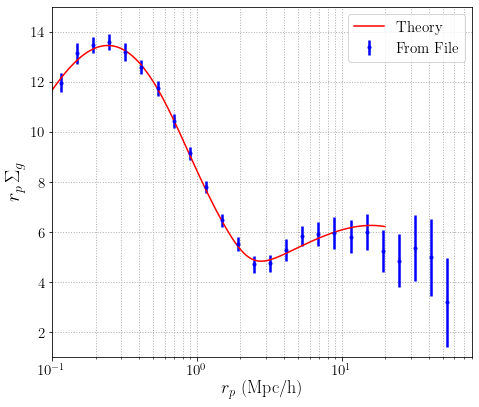

In [66]:
fig, ax = pl.subplots(1,1, figsize = (7,6))
facm = 1.0
rp_pt = 20
# ax.plot(facm*rp_arr,facm*rp_arr*Sigma_g_arr_DK, color='k',lw=2,ls='-',label=r'No Miscentering')
# ax.plot(facm*rp_arr,facm*rp_arr*Sigma_g_arr_DK_wmis, color='r',lw=2,ls='-',label=r'With Miscentering')

ind_sel = np.where(rp_arr <= rp_pt)[0]
# ax.plot(facm*rp_arr[ind_sel],(facm*rp_arr*(Sigma_g_arr_DK_wmis-Sigma_g_arr_DK_wmis_mean))[ind_sel], color='r',lw=2,ls='-',label=r'Theory DK')
# ax.plot(facm*rp_arr[ind_sel],(facm*rp_arr*(Sigma_g_arr_DK_wmis))[ind_sel], color='r',lw=2,ls='-',label=r'Theory DK')

# ax.plot(facm*rp_arr[ind_sel],(facm*rp_arr*(Sigma_g_arr_DK_wmis-Sigma_g_arr_DK_wmis_mean))[ind_sel], color='k',lw=2,ls='-',label=r'$\Sigma(R) - \bar{\Sigma}$')
ax.plot(facm*rp_arr[ind_sel],(facm*rp_arr*(Sigma_g_arr_DK_wmis))[ind_sel], color='r',lw=1.5,ls='-',label=r'Theory')


# ind_sel = np.where(rp_cen > rp_pt)[0]
# ax.plot(rp_cen[ind_sel],(rp_cen*Sigmag_mm_nl_val*5.*1.6*(1./2.9))[ind_sel], color='k',lw=2.5,ls='-',label=r'Theory PT')
ax.errorbar(rp_data2,rp_data2*sig_cg_data, rp_data2*np.sqrt(np.diag(df1['cov'])),color='b',lw=2.5,ls='',marker='o',ms=3.0, label='From File')
# ax.errorbar(dv2[:,0],dv2[:,1],color='k',lw=2.5,ls='',marker='o',ms=5.0,label='From Draft')
ax.grid(which='both',ls=':',lw=1.0)
ax.set_xscale('log')
# ax.set_yscale('log')
ax.set_xlabel(r'$r_p$ (Mpc/h)', size = 18)
ax.set_ylabel(r'$r_p \, \Sigma_g$', size = 20)
# ax.set_ylim(1e-2,2e2)
ax.set_ylim(1e0,15)
ax.set_xlim(0.1,80)
ax.tick_params(axis='both', which='major', labelsize=15)
ax.tick_params(axis='both', which='minor', labelsize=15)
ax.legend(fontsize = 15,loc='upper right')
pl.tight_layout()




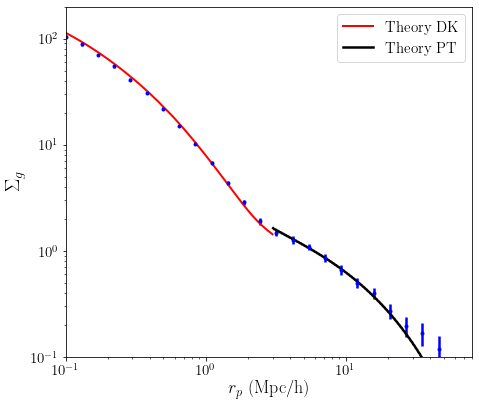

In [278]:
fig, ax = pl.subplots(1,1, figsize = (7,6))
facm = 1.0
rp_pt = 3
# ax.plot(facm*rp_arr,facm*rp_arr*Sigma_g_arr_DK, color='k',lw=2,ls='-',label=r'No Miscentering')
# ax.plot(facm*rp_arr,facm*rp_arr*Sigma_g_arr_DK_wmis, color='r',lw=2,ls='-',label=r'With Miscentering')

ind_sel = np.where(rp_arr <= rp_pt)[0]
ax.plot(facm*rp_arr[ind_sel],(facm*(Sigma_g_arr_DK_wmis-Sigma_g_arr_DK_wmis_mean) )[ind_sel], color='r',lw=2,ls='-',label=r'Theory DK')

ind_sel = np.where(rp_cen > rp_pt)[0]
ax.plot(rp_cen[ind_sel],(Sigmag_mm_nl_val*5.*1.6*(14))[ind_sel], color='k',lw=2.5,ls='-',label=r'Theory PT')
ax.errorbar(rp_data2,sig_cg_data, np.sqrt(np.diag(df1['cov'])),color='b',lw=2.5,ls='',marker='o',ms=3.0)

ax.set_xscale('log')
ax.set_yscale('log')
ax.set_xlabel(r'$r_p$ (Mpc/h)', size = 18)
ax.set_ylabel(r'$\Sigma_g$', size = 20)
ax.set_ylim(1e-1,2e2)
# ax.set_ylim(1e0,15)
ax.set_xlim(0.1,80)
ax.tick_params(axis='both', which='major', labelsize=15)
ax.tick_params(axis='both', which='minor', labelsize=15)
ax.legend(fontsize = 15,loc='upper right')
pl.tight_layout()




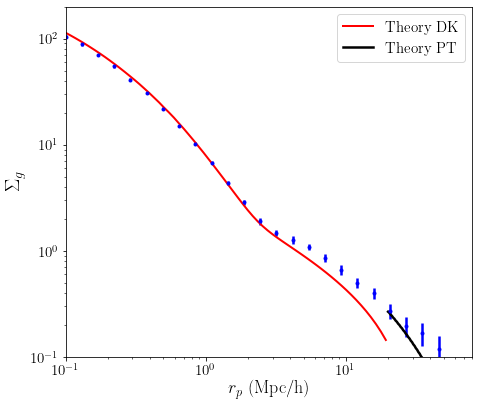

In [280]:
fig, ax = pl.subplots(1,1, figsize = (7,6))
facm = 1.0
rp_pt = 20
# ax.plot(facm*rp_arr,facm*rp_arr*Sigma_g_arr_DK, color='k',lw=2,ls='-',label=r'No Miscentering')
# ax.plot(facm*rp_arr,facm*rp_arr*Sigma_g_arr_DK_wmis, color='r',lw=2,ls='-',label=r'With Miscentering')

ind_sel = np.where(rp_arr <= rp_pt)[0]
ax.plot(facm*rp_arr[ind_sel],(facm*(Sigma_g_arr_DK_wmis-Sigma_g_arr_DK_wmis_mean) )[ind_sel], color='r',lw=2,ls='-',label=r'Theory DK')

ind_sel = np.where(rp_cen > rp_pt)[0]
ax.plot(rp_cen[ind_sel],(Sigmag_mm_nl_val*5.*1.6*(14))[ind_sel], color='k',lw=2.5,ls='-',label=r'Theory PT')
ax.errorbar(rp_data2,sig_cg_data, np.sqrt(np.diag(df1['cov'])),color='b',lw=2.5,ls='',marker='o',ms=3.0)

ax.set_xscale('log')
ax.set_yscale('log')
ax.set_xlabel(r'$r_p$ (Mpc/h)', size = 18)
ax.set_ylabel(r'$\Sigma_g$', size = 20)
ax.set_ylim(1e-1,2e2)
# ax.set_ylim(1e0,15)
ax.set_xlim(0.1,80)
ax.tick_params(axis='both', which='major', labelsize=15)
ax.tick_params(axis='both', which='minor', labelsize=15)
ax.legend(fontsize = 15,loc='upper right')
pl.tight_layout()




In [ ]:
R_array = theta_array_rad * self.PS_prepDV.cosmo_colossus.angularDiameterDistance(
    np.mean(self.PS_prepDV.z_array))

Rmis_array = np.logspace(-4, 1, 28)
psi_array = np.linspace(0, 2 * np.pi, 28)
cospsi_array = np.cos(psi_array)
nRmis = len(Rmis_array)
npsi = len(psi_array)

Rmis_nRmis_npsi = (np.tile(Rmis_array.reshape(1, nRmis, 1), (ntheta, 1, npsi)))
cospsi_nRmis_npsi = (np.tile(cospsi_array.reshape(1, 1, npsi), (ntheta, nRmis, 1)))

theta_min_rad_full = theta_min
theta_max_rad_full = theta_max
theta_array_rad_full = np.logspace(np.log10(theta_min_rad_full), np.log10(theta_max_rad_full), 3800)
ntheta_full = len(theta_array_rad_full)

Rmat_nRmis_npsi = (np.tile(R_array.reshape(ntheta, 1, 1), (1, nRmis, npsi)))

R_arg_new = np.sqrt(
    Rmat_nRmis_npsi ** 2 + Rmis_nRmis_npsi ** 2 + 2 * Rmat_nRmis_npsi * Rmis_nRmis_npsi * cospsi_nRmis_npsi)

Cly_theta_interp = interpolate.interp1d(R_array, Cl_yg_theta, fill_value=0.0, bounds_error=False)
Cly_theta_argnew = Cly_theta_interp(R_arg_new)

Cly_intpsi = (1. / (2 * np.pi)) * sp.integrate.simps(Cly_theta_argnew, psi_array)

sigmaR_val = self.PS_prepDV.cmis * np.mean(self.PS_prepDV.r_vir_mat)

sigmaR_mat = (np.tile(sigmaR_val.reshape(1, 1), (ntheta, nRmis)))
Rmis_mat = (np.tile(Rmis_array.reshape(1, nRmis), (ntheta, 1)))
PRmis_mat = (Rmis_mat / sigmaR_mat ** 2) * np.exp(-1. * ((Rmis_mat ** 2) / (2. * sigmaR_mat ** 2)))

Cly_intRmis = sp.integrate.simps(Cly_intpsi * PRmis_mat, Rmis_array)

if np.all(Cly_intRmis > 0):
    Cly_intRmis_interp = interpolate.interp1d(np.log(theta_array_rad), np.log(Cly_intRmis))
    Cly_misc_theta = np.exp(Cly_intRmis_interp(np.log(theta_array_rad_full)))

else:
    # print 'negative values in Cly_intRmis. Careful about extrapolation!!!!'
    Cly_intRmis_interp = interpolate.interp1d(np.log(theta_array_rad), Cly_intRmis)
    Cly_misc_theta = (Cly_intRmis_interp(np.log(theta_array_rad_full)))

Cly_misc_theta_full = np.tile(Cly_misc_theta.reshape(1, ntheta_full), (nl, 1))
l_thetafull = (np.tile(l_array.reshape(nl, 1), (1, ntheta_full))) * (
    np.tile(theta_array_rad_full.reshape(1, ntheta_full), (nl, 1)))
j0_lthetafull = sp.special.jv(0, l_thetafull)
theta_mat = (np.tile(theta_array_rad_full.reshape(1, ntheta_full), (nl, 1)))
Cly_misc_l = (2 * np.pi) * (
    sp.integrate.simps(theta_mat * Cly_misc_theta_full * j0_lthetafull, theta_array_rad_full))

Cly_misc_l_final = self.PS_prepDV.fmis * Cly_misc_l + (1 - self.PS_prepDV.fmis) * Cl_yg



In [ ]:
fig, ax = pl.subplots(1,1, figsize = (7,6))
indz = np.where(PS.z_array > 0.1)[0][0]
ax.plot(r,(xitot_lin_mat)[indz,:], color='r',lw=2,ls='-',label=r'$z=0.1$')
indz = np.where(PS.z_array > 0.5)[0][0]
ax.plot(r,(xitot_lin_mat)[indz,:], color='b',lw=2,ls='-',label=r'$z=0.5$')
indz = np.where(PS.z_array > 0.79)[0][0]
ax.plot(r,(xitot_lin_mat)[indz,:], color='k',lw=2,ls='-',label=r'$z=0.8$')

ax.set_xscale('log')
ax.set_yscale('log')
ax.set_xlabel(r'$r$ (Mpc/h)', size = 18)
ax.set_ylabel(r'$\xi^{\rm 3D}_{\rm cm}$', size = 20)
ax.set_ylim(1e-2,4e4)
ax.set_xlim(0.1,70)
ax.tick_params(axis='both', which='major', labelsize=15)
ax.tick_params(axis='both', which='minor', labelsize=15)
ax.legend(fontsize = 18, frameon = False)
pl.tight_layout()





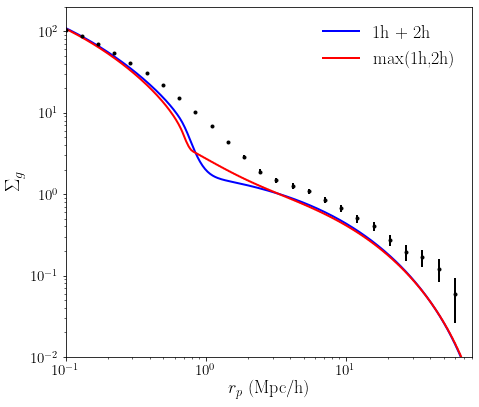

In [280]:
fig, ax = pl.subplots(1,1, figsize = (7,6))
# indz = np.where(PS.z_array > 0.7)[0][0]
# ax.plot(rp_cen,(wprp_tot_mat)[indz,:], color='r',lw=2,ls='-')
ax.plot(rp_cen,(Sigma_cg_tot_norm), color='b',lw=2,ls='-',label=r'1h + 2h')
ax.plot(rp_cen,(Sigma_cg_tot_norm_tot_maxr), color='r',lw=2,ls='-',label=r'max(1h,2h)')
# ax.plot(rp_cen,(1/80)*(Sigma_cg_tot_norm_smooth2), color='k',lw=2,ls='-',label=r'$\alpha=0.5$')
# ax.errorbar(rp_data2,xi_cg_data,color='b',lw=2,ls='',marker='o',ms=3.0)
ax.errorbar(rp_data2,sig_cg_data, np.sqrt(np.diag(df1['cov'])),color='k',lw=2,ls='',marker='o',ms=3.0)


ax.set_xscale('log')
ax.set_yscale('log')
ax.set_xlabel(r'$r_p$ (Mpc/h)', size = 18)
ax.set_ylabel(r'$\Sigma_g$', size = 20)
ax.set_ylim(1e-2,2e2)
ax.set_xlim(0.1,80)
ax.tick_params(axis='both', which='major', labelsize=15)
ax.tick_params(axis='both', which='minor', labelsize=15)
ax.legend(fontsize = 18, frameon = False)
pl.tight_layout()





In [381]:
from mcfit import P2xi
from mcfit import xi2P
import scipy.interpolate as interpolate
from mcfit import Hankel
k_array_hres = np.logspace(-4.8,np.log10(1000),100000)

# wprp_tot_mat = np.zeros((Pk1h.shape[0], len(k_array) - 1))
num_mat = np.zeros(((len(k_array) - 1),Pk1h.shape[0]))
# units = PS.rho_m_bar
nz_array = nz_interp(PS.z_array)/sp.integrate.simps(nz_interp(PS.z_array),PS.z_array)
for jz in range(len(PS.z_array)):
    rp_out, wprp_out = Hankel(k_array, nu=0, q=1.0)(Pk1h_cg[jz,:] + Pk2h_cg_lin[jz,:] - Pk1h_cg[jz,-1], extrap=True)
    wprp_out *= (1 / (2 * np.pi))
    drp_out = rp_out[1:] - rp_out[:-1]
    rp_cen = 0.5*(rp_out[1:] + rp_out[:-1])
    
    wprp_cen = 0.5*(wprp_out[1:] + wprp_out[:-1])
    num_mat[:,jz] = wprp_cen * nbarg_array[jz] * (PS.chi_array[jz] ** 2) * (nz_array[jz])

num_final = sp.integrate.simps(num_mat,PS.z_array)
denom_final = sp.integrate.simps(nbarg_array,PS.chi_array)
N_tot = sp.integrate.simps(nbarg_array * (PS.chi_array[jz] ** 2),PS.chi_array )
Sigma_g_measure = num_final*denom_final/N_tot


    

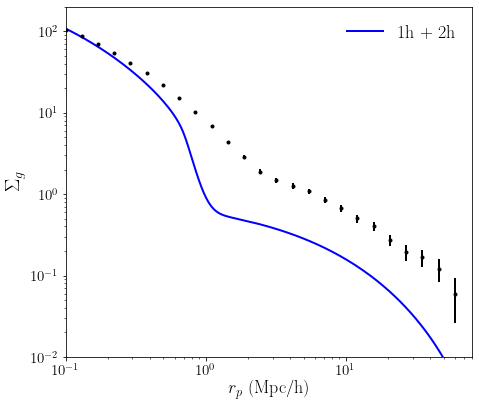

In [382]:
fig, ax = pl.subplots(1,1, figsize = (7,6))
# indz = np.where(PS.z_array > 0.7)[0][0]
# ax.plot(rp_cen,(wprp_tot_mat)[indz,:], color='r',lw=2,ls='-')
ax.plot(rp_cen,(Sigma_g_measure), color='b',lw=2,ls='-',label=r'1h + 2h')
# ax.plot(rp_cen,(Sigma_cg_tot_norm_tot_maxr), color='r',lw=2,ls='-',label=r'max(1h,2h)')
# ax.plot(rp_cen,(1/80)*(Sigma_cg_tot_norm_smooth2), color='k',lw=2,ls='-',label=r'$\alpha=0.5$')
# ax.errorbar(rp_data2,xi_cg_data,color='b',lw=2,ls='',marker='o',ms=3.0)
ax.errorbar(rp_data2,sig_cg_data, np.sqrt(np.diag(df1['cov'])),color='k',lw=2,ls='',marker='o',ms=3.0)


ax.set_xscale('log')
ax.set_yscale('log')
ax.set_xlabel(r'$r_p$ (Mpc/h)', size = 18)
ax.set_ylabel(r'$\Sigma_g$', size = 20)
ax.set_ylim(1e-2,2e2)
ax.set_xlim(0.1,80)
ax.tick_params(axis='both', which='major', labelsize=15)
ax.tick_params(axis='both', which='minor', labelsize=15)
ax.legend(fontsize = 18, frameon = False)
pl.tight_layout()





In [68]:
nx = 50
nm = 80
nz = 1
x_array = np.linspace(0.1,4,nx)
M_array = np.logspace(10,16,nm)
Mmat = np.array([M_array])
zarr = np.array([0.193])
rho_crit = cosmo_colossus.rho_c(zarr) * (1000 ** 3)
R_mat = hmf.get_R_from_M_mat(Mmat,200*rho_crit)

y3d_mat = Pfid.get_y3d(Mmat, x_array, zarr, R_mat, M200c_mat=Mmat, mdef_M_mat='200c')

# nz, nm, nx = 1, 1, len(x_array)
x_mat = np.tile(x_array.reshape(1, 1, nx), (nz, nm, 1))

chi_array = hmf.get_Dcom_array(zarr, cosmo_params_dict['Om0'])
DA_array = chi_array / (1. + zarr)

DA_mat_coeff = np.tile(DA_array.reshape(nz, 1), (1, nm))
rmdefP_mat_coeff = R_mat
lmdefP_mat_coeff = DA_mat_coeff / rmdefP_mat_coeff

x_mat_lmdefP_mat = x_mat / np.tile(lmdefP_mat_coeff.reshape(nz, nm, 1), (1, 1, nx))
coeff_mat_y = 4 * np.pi * rmdefP_mat_coeff / (lmdefP_mat_coeff ** 2)

x_mat2_y3d_mat = (x_mat ** 2) * y3d_mat
# ghmf = general_hm(cosmo_params_dict, pressure_params_dict, other_params_dict)
dndm_array, bm_array = get_dndm_bias(Mmat,zarr, '200c')



In [79]:
y3d_mat.shape


(1, 80, 50)

In [69]:
k_array = np.logspace(-5,2,100)
byk_array = np.zeros(len(k_array))
for jk in range(len(k_array)):
    lv = k_array[jk] * chi_array - 0.5
#     print(lv.shape)
#     temp_mat = k_array[jk] * (x_array * )
#     uyk_array_jk = sp.integrate.simps(x_mat2_y3d_mat * ) * 
    byk_array[jk] = sp.integrate.simps(dndm_array * bm_array, uyk_array_jk,M_array)
    
    
    

In [70]:
# other_params_dict.keys()

pklin = np.exp(other_params_dict['pkzlin_interp'].ev(zarr, np.log(k_array))) 


In [71]:
Mh = np.array([np.array([1e15])])
_, bmh = get_dndm_bias(Mh,zarr, '200c')
P_hy_2h = bmh * byk_array * pklin



In [72]:
from mcfit import P2xi
# r, xi = P2xi(k)(P)

rv, xi_hy_2h = P2xi(k_array)(P_hy_2h)



In [74]:
x_array = np.linspace(0.1,10,100)
# Mmat = np.array([np.array([1e15])])
# zarr = np.array([0.193])
# rho_crit = cosmo_colossus.rho_c(zarr) * (1000 ** 3)
Rh = hmf.get_R_from_M_mat(Mh,200*rho_crit)

y3dh = Pfid.get_y3d(Mh, x_array, zarr, Rh, M200c_mat=Mh, mdef_M_mat='200c')




In [71]:
len(PS.z_array)


100

In [172]:
rp_min = 0.001
rp_max = 60
nrp = 50
lmax = 40
rp_arr = np.logspace(np.log10(rp_min), np.log10(rp_max),nrp)
rp_DK = 5
ind_DK = np.where(rp_arr>rp_DK)[0][0]
Sigma_g_arr_DK_PT = np.zeros((len(PS.z_array),nrp))
Sigma_g_arr_DK = np.zeros((len(PS.z_array),nrp))
Sigma_g_arr_PT = np.zeros((len(PS.z_array),nrp))
for jrp in range(nrp):
    rpv = rp_arr[jrp]
    yarr = np.logspace(np.log10(1.0001*rpv),np.log10(np.sqrt(rpv**2 +lmax**2)),10000)
    rho_yarr1, _, _, _ = get_DK_prof(yarr)
    int_yarr = 2.*rho_yarr1 * yarr/np.sqrt(yarr**2 - rpv**2)
    sig_g_v_DK = sp.integrate.simps(int_yarr, yarr)
    
    for jz in range(len(PS.z_array)):
        
        xicg1 = (5.*1.6)* (xinl_interp((PS.z_array[jz])*np.ones_like(yarr),np.log(yarr),grid=False))/(yarr**2)
        
        int_yarr = 2.*xicg1 * yarr/np.sqrt(yarr**2 - rpv**2)
        Sigma_g_arr_PT[jz,jrp] = sp.integrate.simps(int_yarr, yarr)
        
        Sigma_g_arr_DK[jz,jrp] = sig_g_v_DK 
        
        xi_tot = np.zeros_like(xicg1)
        ind_sel = np.where(yarr > rp_DK)[0]
        if len(ind_sel) > 0:
            xi_tot[ind_sel] = xicg1[ind_sel]
        
        ind_sel = np.where(yarr <= rp_DK)[0]
        if len(ind_sel) > 0:
#             amp_to_mul = xicg1[ind_sel[-1]]/rho_yarr1[ind_sel[-1]]
            amp_to_mul = 1./Sigmag_cg_val_const[0]
            xi_tot[ind_sel] = amp_to_mul*rho_yarr1[ind_sel]
        int_yarr = 2.*xi_tot * yarr/np.sqrt(yarr**2 - rpv**2)
        Sigma_g_arr_DK_PT[jz,jrp] = sp.integrate.simps(int_yarr, yarr)
        

In [173]:
wprp_cg_tot_interp = interpolate.RectBivariateSpline(PS.z_array, np.log(rp_arr), np.log(Sigma_g_arr_DK_PT))   



In [174]:

# fig, ax = pl.subplots(1,1, figsize = (7,6))
# # ax.plot(rp_cen,wprp_mm_nl_mat[10,:], color='b',lw=2,ls='-',label=r'From $P(k)$')
# ax.plot(rp_arr,Sigma_g_arr_PT[10,:], color='r',lw=2,ls='-',label=r'From PT')

# ax.plot(rp_arr,Sigma_g_arr_DK_PT[10,:], color='k',lw=2,ls='-',label=r'From DK + PT')

# # ax.plot(rp_arr,Sigma_g_arr_PT[20,:], color='r',lw=2,ls='-',label=r'From PT2')
# # ax.plot(rp_arr,Sigma_g_arr_PT[30,:], color='r',lw=2,ls='-',label=r'From PT3')
# # ax.plot(rp_arr,Sigma_g_arr_DK[30,:], color='k',lw=2,ls='-',label=r'From DK')
# ax.set_xscale('log')
# ax.set_yscale('log')
# ax.set_xlabel(r'$r_p$ (Mpc/h)', size = 18)
# ax.set_ylabel(r'$\Sigma_g$', size = 20)
# ax.set_ylim(1e-1,5e4)
# ax.set_xlim(0.01,80)
# ax.tick_params(axis='both', which='major', labelsize=15)
# ax.tick_params(axis='both', which='minor', labelsize=15)
# ax.legend(fontsize = 18, frameon = False)
# pl.tight_layout()






In [175]:
dfg = np.load('nofz_z0.15-0.7_bpz_y3gold_m22.5_M-19.87_new.npz')
zg_all = zarr_cen
zg_all = zarr_cen
zc_all = dfg['zbins']
dzc = zc_all[1] - zc_all[0]
zc_all_ext = np.hstack(([zc_all[0] - dzc], zc_all, [zc_all[-1] + dzc]))
zc_edges_all = 0.5*(zc_all_ext[1:] + zc_all_ext[:-1])
zc_edges_min = zc_edges_all[:-1]
zc_edges_max = zc_edges_all[1:]
chi_interp = interpolate.interp1d(PS.z_array,np.log(PS.chi_array))
Sigma_g_meanv2 = 0
nc_total = 0
Sigma_g_bar_zarr = np.zeros(len(zc_all))
Sigma_g_mean_weighted = 0
for jc in range(len(zc_all)):
    ng_unnorm = dfg['count'][jc,:]
    Ng_tot = np.sum(ng_unnorm)
    chiv = np.exp(chi_interp(zc_all[jc]))
    area = (4*np.pi*0.108)*(chiv**2)
    ind_sel = np.where((dfc['z'] >= zc_edges_min[jc])  & (dfc['z'] < zc_edges_max[jc]))[0]
    nc_val = len(ind_sel)
    Sigma_g_meanv2 += nc_val * Ng_tot/area
    nc_total += nc_val
    Sigma_g_bar_zarr[jc] = Ng_tot/area
    
Sigma_g_meanv2 = Sigma_g_meanv2/nc_total

chi_interp = interpolate.interp1d(PS.z_array, np.log(PS.chi_array),fill_value='extrapolate')
chi_cen = np.exp(chi_interp(zarr_cen))

dchi_dz_interp = interpolate.interp1d(PS.z_array, np.log(PS.dchi_dz_array),fill_value='extrapolate')
dchi_dz_cen = np.exp(dchi_dz_interp(zarr_cen))


zcen_hres = np.linspace(0.05,1.0,500)
dzc = zcen_hres[1] - zcen_hres[0]
zcen_hres_all_ext = np.hstack(([zcen_hres[0] - dzc], zcen_hres, [zcen_hres[-1] + dzc]))
zcen_hres_edges = 0.5*(zcen_hres_all_ext[1:] + zcen_hres_all_ext[:-1])

zarr_cen = 0.5*(dfg['zbins_nz'][1:] + dfg['zbins_nz'][:-1])
ng_norm_hres = np.zeros((len(dfg['zbins']),len(zcen_hres)))
for jz in range(len(dfg['zbins'])):
    ng_unnorm = dfg['count'][jz,:]
#     ng_unnorm = dfg2['hist'][jz,:]
    ng_norm = ng_unnorm/sp.integrate.simps(ng_unnorm,zarr_cen)
    ng_interp = interpolate.interp1d(zarr_cen,ng_norm)
    ng_norm_hres[jz,:] = ng_interp(zcen_hres)
    
chi_cen_hres = np.exp(chi_interp(zcen_hres))
dchi_dz_cen_hres = np.exp(dchi_dz_interp(zcen_hres))

nc_intp = interpolate.interp1d(bin_centers,nc_norm)
ell_array = np.logspace(-1,5,100)
rp_array = np.logspace(-3,2,100)
theta_all = np.zeros((len(rp_array),len(zc_all)))
nc_mat_all = np.zeros((len(rp_array),len(zc_all)))

wt_all2 = np.zeros((len(rp_array),len(zc_all)))

for jc in range(len(zc_all)):
# for jc in range(1):
    ng_unnorm = ng_norm_hres[jc,:]
    ng_norm_jc = ng_unnorm/sp.integrate.simps(ng_unnorm,zcen_hres)
    
    ind_sel = np.where((dfc['z'] >= zc_edges_min[jc])  & (dfc['z'] < zc_edges_max[jc]))[0]
    nz_hist, z_edges = np.histogram(dfc['z'][ind_sel], bins=zcen_hres_edges)
    nc_norm_jc = nz_hist/sp.integrate.simps(nz_hist,zcen_hres)  

    ng_norm_interp_jc = interpolate.interp1d(zcen_hres, ng_norm_jc)
    ngv_jc = ng_norm_interp_jc(zc_all[jc])
    chiv_jc = np.exp(chi_interp(zc_all[jc]))
    dchidzv_jc = np.exp(dchi_dz_interp(zc_all[jc]))
        
#     wprp_all2 = (wprp_cg_tot_interp((zc_all[jc])*np.ones_like(rp_array),np.log(rp_array),grid=False))/rp_array
    wprp_all2 = np.exp(wprp_cg_tot_interp((zc_all[jc])*np.ones_like(rp_array),np.log(rp_array),grid=False))

    wt_all2[:,jc] = (ngv_jc/(dchidzv_jc))*wprp_all2
    
    nc_val = nc_intp(zc_all[jc])
    nc_mat_all[:,jc] = nc_val * np.ones(len(rp_array))    
    
Sigmag_bar = Sigma_g_meanv2

Sigmag_cg_val_DK_PT = Sigmag_bar * sp.integrate.simps((wt_all2*nc_mat_all),zc_all)/(sp.integrate.simps((nc_mat_all),zc_all))



In [176]:
# Rmis_array = np.logspace(-3, np.log10(1.569), 200)
Rmis_array = np.linspace(0, (1.569), 200)
psi_array = np.linspace(0, 2 * np.pi, 50)
cospsi_array = np.cos(psi_array)
nRmis = len(Rmis_array)
npsi = len(psi_array)
nrp2 = len(rp_array)
Rmis_nRmis_npsi = (np.tile(Rmis_array.reshape(1, nRmis, 1), (nrp2, 1, npsi)))
cospsi_nRmis_npsi = (np.tile(cospsi_array.reshape(1, 1, npsi), (nrp2, nRmis, 1)))
Rmat_nRmis_npsi = (np.tile(rp_array.reshape(nrp2, 1, 1), (1, nRmis, npsi)))
R_arg_new = np.sqrt(
    Rmat_nRmis_npsi ** 2 + Rmis_nRmis_npsi ** 2 + 2 * Rmat_nRmis_npsi * Rmis_nRmis_npsi * cospsi_nRmis_npsi)



# Sigmag_interp = interpolate.interp1d(rp_arr, Sigma_g_arr_DK, fill_value=0.0, bounds_error=False)
# Sigmag_interp = interpolate.interp1d(rp_arr, Sigma_g_arr_DK, fill_value='extrapolate')
Sigmag_interp = interpolate.interp1d(np.hstack((0.0001,rp_array)),np.hstack((Sigmag_cg_val_DK_PT[0],Sigmag_cg_val_DK_PT)),fill_value = "extrapolate")
Sigmag_argnew = Sigmag_interp(R_arg_new)

# Sigmag_intpsi = (1. / (2 * np.pi)) * sp.integrate.simps(Sigmag_argnew, psi_array)
Sigmag_intpsi = np.mean(Sigmag_argnew,axis=2)
# Sigmag_intpsi =  sp.integrate.simps(Sigmag_argnew, psi_array)
sigmaR_val = cmisg * 0.92

sigmaR_mat = (np.tile(sigmaR_val.reshape(1, 1), (nrp2, nRmis)))
Rmis_mat = (np.tile(Rmis_array.reshape(1, nRmis), (nrp2, 1)))
PRmis_mat = (Rmis_mat / sigmaR_mat ** 2) * np.exp(-1. * ((Rmis_mat ** 2) / (2. * sigmaR_mat ** 2)))

# Sigmag_intRmis = sp.integrate.simps(Sigmag_intpsi * PRmis_mat, Rmis_array)
Sigmag_intRmis = np.average(Sigmag_intpsi,weights=PRmis_mat, axis=1)
# Sigmag_intRmis = sp.integrate.simps(sigmaR_val*Sigmag_intpsi * PRmis_mat, Rmis_array)

Sigma_g_arr_DK_PT_wmis = (1. - fmisg)*Sigmag_cg_val_DK_PT + fmisg*Sigmag_intRmis



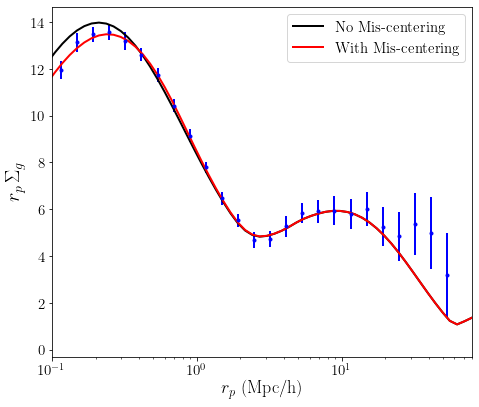

In [177]:
fig, ax = pl.subplots(1,1, figsize = (7,6))
# ax.plot(rp_cen,6*6*(Sigmag_mm_nl_norm*Sigma_g_mean2), color='r',lw=2,ls='-',label=r'Theory; PT w/$\langle b_c \rangle = 5.0, \langle b_g \rangle = 1.7$')
# ax.plot(rp_cen,4*(Sigmag_cg_nl_norm*Sigma_g_mean2), color='k',lw=2,ls='-',label=r'Theory; HOD w/$M_{\rm min} = 1.5\times 10^{14}M_{\odot}/h$'
       

ax.plot(rp_array,rp_array*Sigmag_cg_val_DK_PT, color='k',lw=2,ls='-',label=r'No Mis-centering')
ax.plot(rp_array,rp_array*Sigma_g_arr_DK_PT_wmis, color='r',lw=2,ls='-',label=r'With Mis-centering')
# ax.plot(rp_array,rp_array*Sigmag_mm_nl_val_bpz*5.*1.5, color='r',lw=2,ls='-',label=r'BPZ')
# ax.plot(rp_cen,rp_cen*Sigmag_cg_2hnl_val*12.56, color='r',lw=2,ls='-',label=r'Theory HOD')
ax.errorbar(rp_data2,rp_data2*sig_cg_data, rp_data2*np.sqrt(np.diag(df1['cov'])),color='b',lw=2,ls='',marker='o',ms=3.0)
# ax.errorbar(rp_data2,sig_cg_data, rp_data2*np.sqrt(np.diag(df1['cov'])),color='b',lw=2,ls='',marker='o',ms=3.0)

ax.set_xscale('log')
# ax.set_yscale('log')
ax.set_xlabel(r'$r_p$ (Mpc/h)', size = 18)
ax.set_ylabel(r'$r_p \,\Sigma_g$', size = 20)
# ax.set_ylim(1e-2,2e2)
# ax.set_ylim(2e0,14)
ax.set_xlim(0.1,80)
ax.tick_params(axis='both', which='major', labelsize=15)
ax.tick_params(axis='both', which='minor', labelsize=15)
ax.legend(fontsize = 15,loc='upper right')
pl.tight_layout()





In [164]:
Sigma_g_arr_DK_PT_wmis_rm15 = Sigma_g_arr_DK_PT_wmis



In [178]:
Sigma_g_arr_DK_PT_wmis_rm5 = Sigma_g_arr_DK_PT_wmis



In [171]:
Sigma_g_arr_DK_PT_wmis_rm10 = Sigma_g_arr_DK_PT_wmis


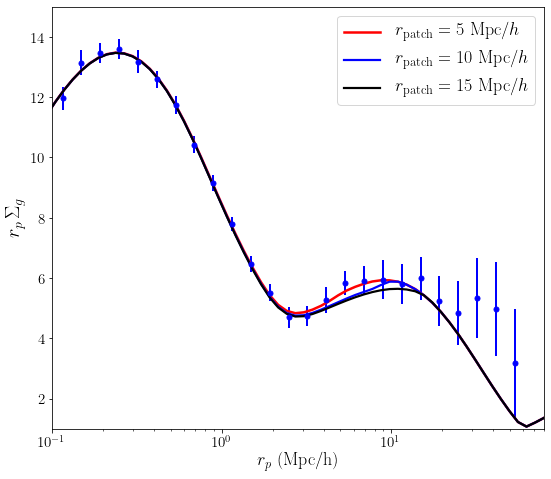

In [185]:
fig, ax = pl.subplots(1,1, figsize = (8,7))
# ax.plot(rp_cen,6*6*(Sigmag_mm_nl_norm*Sigma_g_mean2), color='r',lw=2,ls='-',label=r'Theory; PT w/$\langle b_c \rangle = 5.0, \langle b_g \rangle = 1.7$')
# ax.plot(rp_cen,4*(Sigmag_cg_nl_norm*Sigma_g_mean2), color='k',lw=2,ls='-',label=r'Theory; HOD w/$M_{\rm min} = 1.5\times 10^{14}M_{\odot}/h$'
       
ax.plot(rp_array,rp_array*Sigma_g_arr_DK_PT_wmis_rm5, color='r',lw=2.5,ls='-',label=r'$r_{\rm patch} = 5$ Mpc/$h$')
ax.plot(rp_array,rp_array*Sigma_g_arr_DK_PT_wmis_rm10, color='b',lw=2.2,ls='-',label=r'$r_{\rm patch} = 10$ Mpc/$h$')
ax.plot(rp_array,rp_array*Sigma_g_arr_DK_PT_wmis_rm15, color='k',lw=2.2,ls='-',label=r'$r_{\rm patch} = 15$ Mpc/$h$')
ax.errorbar(rp_data2,rp_data2*sig_cg_data, rp_data2*np.sqrt(np.diag(df1['cov'])),color='b',lw=2,ls='',marker='o',ms=5.0)
# ax.errorbar(rp_data2,sig_cg_data, rp_data2*np.sqrt(np.diag(df1['cov'])),color='b',lw=2,ls='',marker='o',ms=3.0)

ax.set_xscale('log')
# ax.set_yscale('log')
ax.set_xlabel(r'$r_p$ (Mpc/h)', size = 18)
ax.set_ylabel(r'$r_p \,\Sigma_g$', size = 20)
# ax.set_ylim(1e-2,2e2)
ax.set_ylim(1e0,15)
ax.set_xlim(0.1,80)
ax.tick_params(axis='both', which='major', labelsize=15)
ax.tick_params(axis='both', which='minor', labelsize=15)
ax.legend(fontsize = 18,loc='upper right')
pl.tight_layout()





In [150]:

wt_const = np.zeros((len(rp_array),len(zc_all)))

for jc in range(len(zc_all)):
# for jc in range(1):
    ng_unnorm = ng_norm_hres[jc,:]
    ng_norm_jc = ng_unnorm/sp.integrate.simps(ng_unnorm,zcen_hres)
    
    ind_sel = np.where((dfc['z'] >= zc_edges_min[jc])  & (dfc['z'] < zc_edges_max[jc]))[0]
    nz_hist, z_edges = np.histogram(dfc['z'][ind_sel], bins=zcen_hres_edges)
    nc_norm_jc = nz_hist/sp.integrate.simps(nz_hist,zcen_hres)  

    ng_norm_interp_jc = interpolate.interp1d(zcen_hres, ng_norm_jc)
    ngv_jc = ng_norm_interp_jc(zc_all[jc])
    chiv_jc = np.exp(chi_interp(zc_all[jc]))
    dchidzv_jc = np.exp(dchi_dz_interp(zc_all[jc]))
        
#     wprp_all2 = (wprp_cg_tot_interp((zc_all[jc])*np.ones_like(rp_array),np.log(rp_array),grid=False))/rp_array
#     wprp_all2 = np.exp(wprp_cg_tot_interp((zc_all[jc])*np.ones_like(rp_array),np.log(rp_array),grid=False))

    wt_const[:,jc] = (ngv_jc/(dchidzv_jc))
    
    nc_val = nc_intp(zc_all[jc])
    nc_mat_all[:,jc] = nc_val * np.ones(len(rp_array))    
    
Sigmag_bar = Sigma_g_meanv2

Sigmag_cg_val_const = Sigmag_bar * sp.integrate.simps((wt_const*nc_mat_all),zc_all)/(sp.integrate.simps((nc_mat_all),zc_all))
print(Sigmag_cg_val_const)


[0.01269296 0.01269296 0.01269296 0.01269296 0.01269296 0.01269296
 0.01269296 0.01269296 0.01269296 0.01269296 0.01269296 0.01269296
 0.01269296 0.01269296 0.01269296 0.01269296 0.01269296 0.01269296
 0.01269296 0.01269296 0.01269296 0.01269296 0.01269296 0.01269296
 0.01269296 0.01269296 0.01269296 0.01269296 0.01269296 0.01269296
 0.01269296 0.01269296 0.01269296 0.01269296 0.01269296 0.01269296
 0.01269296 0.01269296 0.01269296 0.01269296 0.01269296 0.01269296
 0.01269296 0.01269296 0.01269296 0.01269296 0.01269296 0.01269296
 0.01269296 0.01269296 0.01269296 0.01269296 0.01269296 0.01269296
 0.01269296 0.01269296 0.01269296 0.01269296 0.01269296 0.01269296
 0.01269296 0.01269296 0.01269296 0.01269296 0.01269296 0.01269296
 0.01269296 0.01269296 0.01269296 0.01269296 0.01269296 0.01269296
 0.01269296 0.01269296 0.01269296 0.01269296 0.01269296 0.01269296
 0.01269296 0.01269296 0.01269296 0.01269296 0.01269296 0.01269296
 0.01269296 0.01269296 0.01269296 0.01269296 0.01269296 0.0126